# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import sklearn as sk

import dill
dill.load_session("notebook_env.db")

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias


AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0             -1                     2          1            2.0   
1             -1                     1          2            5.0   
2             -1                     3          2            3.0   
3              2                     4          2            2.0   
4             -1                     3          1            5.0   
...          ...                   ...        ...            ...   
891216        -1                     3          2            5.0   
891217        -1                     2          1            4.0   
891218        -1                     2          2            4.0   
891219        -1                     1          1            3.0   
891220        -1                     4          1            1.0   

        FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                       3              4                 3               5   
1                       1              5                 2               5   
2                       1              4                 1               2   
3                       4              2                 5               2   
4                       4              3                 4               1   
...                   ...            ...               ...             ...   
891216                  1              4                 2               5   
891217                  3              3                 3               2   
891218                  2              4                 2               5   
891219                  1              5                 3               5   
891220                  4              2                 5               2   

        FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  ...  PLZ8_ANTG1  PLZ8_ANTG2  \
0                           5                 3  ...         NaN         NaN   
1                           4                 5  ...         2.0         3.0   
2                           3                 5  ...         3.0         3.0   
3                           1                 2  ...         2.0         2.0   
4                           3                 2  ...         2.0         4.0   
...                       ...               ...  ...         ...         ...   
891216                      4                 4  ...         3.0         2.0   
891217                      2                 3  ...         1.0         3.0   
891218                      4                 3  ...         4.0         2.0   
891219                      5                 5  ...         1.0         4.0   
891220                      1                 5  ...         3.0         3.0   

        PLZ8_ANTG3  PLZ8_ANTG4  PLZ8_BAUMAX  PLZ8_HHZ  PLZ8_GBZ  ARBEIT  \
0              NaN         NaN          NaN       NaN       NaN     NaN   
1              2.0         1.0          1.0       5.0       4.0     3.0   
2              1.0         0.0          1.0       4.0       4.0     3.0   
3              2.0         0.0          1.0       3.0       4.0     2.0   
4              2.0         1.0          2.0       3.0       3.0     4.0   
...            ...         ...          ...       ...       ...     ...   
891216         0.0         0.0          1.0       2.0       3.0     NaN   
891217         3.0         2.0          4.0       5.0       3.0     4.0   
891218         0.0         0.0          1.0       3.0       4.0     2.0   
891219         3.0         1.0          5.0       1.0       1.0     4.0   
891220         1.0         0.0          1.0       4.0       4.0     3.0   

        ORTSGR_KLS9  RELAT_AB  
0               NaN       NaN  
1               5.0       4.0  
2               5.0       2.0  
3               3.0       3.0  
4               6.0       5.0  
...             ...       ...  
891216          NaN       NaN  
891217          6.0       5.0  
891218          2.0       3.0  
891219          7.0       5.0  
891220          4.0       5.0  

[891221

In [4]:
feat_info

attribute information_level         type missing_or_unknown
0               AGER_TYP            person  categorical             [-1,0]
1   ALTERSKATEGORIE_GROB            person      ordinal           [-1,0,9]
2              ANREDE_KZ            person  categorical             [-1,0]
3          CJT_GESAMTTYP            person  categorical                [0]
4      FINANZ_MINIMALIST            person      ordinal               [-1]
..                   ...               ...          ...                ...
80              PLZ8_HHZ    macrocell_plz8      ordinal               [-1]
81              PLZ8_GBZ    macrocell_plz8      ordinal               [-1]
82                ARBEIT         community      ordinal             [-1,9]
83           ORTSGR_KLS9         community      ordinal             [-1,0]
84              RELAT_AB         community      ordinal             [-1,9]

[85 rows x 4 columns]

In [5]:
azdias.isna().sum()

AGER_TYP                     0
ALTERSKATEGORIE_GROB         0
ANREDE_KZ                    0
CJT_GESAMTTYP             4854
FINANZ_MINIMALIST            0
                         ...  
PLZ8_HHZ                116515
PLZ8_GBZ                116515
ARBEIT                   97216
ORTSGR_KLS9              97216
RELAT_AB                 97216
Length: 85, dtype: int64

In [6]:
pd.set_option('display.max_rows', None)
print(feat_info)
pd.set_option('display.max_rows', 10)

                attribute information_level         type missing_or_unknown
0                AGER_TYP            person  categorical             [-1,0]
1    ALTERSKATEGORIE_GROB            person      ordinal           [-1,0,9]
2               ANREDE_KZ            person  categorical             [-1,0]
3           CJT_GESAMTTYP            person  categorical                [0]
4       FINANZ_MINIMALIST            person      ordinal               [-1]
5           FINANZ_SPARER            person      ordinal               [-1]
6        FINANZ_VORSORGER            person      ordinal               [-1]
7          FINANZ_ANLEGER            person      ordinal               [-1]
8   FINANZ_UNAUFFAELLIGER            person      ordinal               [-1]
9        FINANZ_HAUSBAUER            person      ordinal               [-1]
10              FINANZTYP            person  categorical               [-1]
11            GEBURTSJAHR            person      numeric                [0]
12        GF

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [7]:
# Identify missing or unknown data values and convert them to NaNs.

# checking out the missing codes:
feat_info

attribute information_level         type missing_or_unknown
0               AGER_TYP            person  categorical             [-1,0]
1   ALTERSKATEGORIE_GROB            person      ordinal           [-1,0,9]
2              ANREDE_KZ            person  categorical             [-1,0]
3          CJT_GESAMTTYP            person  categorical                [0]
4      FINANZ_MINIMALIST            person      ordinal               [-1]
..                   ...               ...          ...                ...
80              PLZ8_HHZ    macrocell_plz8      ordinal               [-1]
81              PLZ8_GBZ    macrocell_plz8      ordinal               [-1]
82                ARBEIT         community      ordinal             [-1,9]
83           ORTSGR_KLS9         community      ordinal             [-1,0]
84              RELAT_AB         community      ordinal             [-1,9]

[85 rows x 4 columns]

In [8]:
feat_info.missing_or_unknown.value_counts()

[-1]        26
[-1,9]      17
[-1,0]      16
[0]         12
[]          10
[-1,0,9]     1
[-1,X]       1
[XX]         1
[-1,XX]      1
Name: missing_or_unknown, dtype: int64

In [9]:
# the missing_or_unknown lists are stored as strings, so they need to be processed into lists.
missing_lists = []
for j in feat_info.missing_or_unknown:
    exlist = list(j)
    symbols = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '0', '-', 'X', 'XX']
    processed = []
    axe = []
    for i in range(0,len(exlist)):
        if exlist[i] in symbols:
            if exlist[i] == '-':
                processed.append((exlist[i]+exlist[i+1]))
                axe.append((exlist[i+1]))
            elif exlist[i] == 'X':
                if exlist[i+1] == 'X':
                    processed.append(exlist[i]+exlist[i+1])
                    axe.append(exlist[i+1])
            else:
                processed.append((exlist[i]))
        if 'X' in processed:
            processed = [str(itm) for itm in processed]
    for i in axe:
        if i in processed:
            processed.remove(i)
    missing_lists.append(list(processed))

In [10]:
# appending the list versions of the missing codes as a new column to feat_info
feat_info['missing_lists'] = missing_lists

In [11]:
feat_info.dtypes

attribute             object
information_level     object
type                  object
missing_or_unknown    object
missing_lists         object
dtype: object

In [12]:
str(azdias.AGER_TYP.dtype)

'int64'

In [13]:
pd.Series(missing_lists).value_counts()

TypeError: unhashable type: 'list'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas\_libs\hashtable_class_helper.pxi", line 5231, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


[-1]          27
[-1, 9]       17
[-1, 0]       16
[0]           12
[]            10
[-1, 0, 9]     1
[XX]           1
[-1, XX]       1
dtype: int64

In [14]:
#deleting missing values for each column
import ipdb
#%debug
icount=0
for i in feat_info.attribute:
    replacers = list(pd.Series([j for j in feat_info.iloc[icount,-1]]).astype(
        str(azdias[i].dtype)))
    azdias[i].replace(to_replace = replacers, value = np.NaN, regex = False, inplace = True)
    icount+=1
azdias

C:\Users\mujta\AppData\Local\Temp/ipykernel_17812/3145535557.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  replacers = list(pd.Series([j for j in feat_info.iloc[icount,-1]]).astype(


AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0            NaN                   2.0          1            2.0   
1            NaN                   1.0          2            5.0   
2            NaN                   3.0          2            3.0   
3            2.0                   4.0          2            2.0   
4            NaN                   3.0          1            5.0   
...          ...                   ...        ...            ...   
891216       NaN                   3.0          2            5.0   
891217       NaN                   2.0          1            4.0   
891218       NaN                   2.0          2            4.0   
891219       NaN                   1.0          1            3.0   
891220       NaN                   4.0          1            1.0   

        FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                       3              4                 3               5   
1                       1              5                 2               5   
2                       1              4                 1               2   
3                       4              2                 5               2   
4                       4              3                 4               1   
...                   ...            ...               ...             ...   
891216                  1              4                 2               5   
891217                  3              3                 3               2   
891218                  2              4                 2               5   
891219                  1              5                 3               5   
891220                  4              2                 5               2   

        FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  ...  PLZ8_ANTG1  PLZ8_ANTG2  \
0                           5                 3  ...         NaN         NaN   
1                           4                 5  ...         2.0         3.0   
2                           3                 5  ...         3.0         3.0   
3                           1                 2  ...         2.0         2.0   
4                           3                 2  ...         2.0         4.0   
...                       ...               ...  ...         ...         ...   
891216                      4                 4  ...         3.0         2.0   
891217                      2                 3  ...         1.0         3.0   
891218                      4                 3  ...         4.0         2.0   
891219                      5                 5  ...         1.0         4.0   
891220                      1                 5  ...         3.0         3.0   

        PLZ8_ANTG3  PLZ8_ANTG4  PLZ8_BAUMAX  PLZ8_HHZ  PLZ8_GBZ  ARBEIT  \
0              NaN         NaN          NaN       NaN       NaN     NaN   
1              2.0         1.0          1.0       5.0       4.0     3.0   
2              1.0         0.0          1.0       4.0       4.0     3.0   
3              2.0         0.0          1.0       3.0       4.0     2.0   
4              2.0         1.0          2.0       3.0       3.0     4.0   
...            ...         ...          ...       ...       ...     ...   
891216         0.0         0.0          1.0       2.0       3.0     NaN   
891217         3.0         2.0          4.0       5.0       3.0     4.0   
891218         0.0         0.0          1.0       3.0       4.0     2.0   
891219         3.0         1.0          5.0       1.0       1.0     4.0   
891220         1.0         0.0          1.0       4.0       4.0     3.0   

        ORTSGR_KLS9  RELAT_AB  
0               NaN       NaN  
1               5.0       4.0  
2               5.0       2.0  
3               3.0       3.0  
4               6.0       5.0  
...             ...       ...  
891216          NaN       NaN  
891217          6.0       5.0  
891218          2.0       3.0  
891219          7.0       5.0  
891220          4.0       5.0  

[891221

In [15]:
# checking that the number of nans has changed
pd.set_option('display.max_rows', None)
nasummary = azdias.isna().sum()
print(nasummary)
pd.set_option('display.max_rows', 10)

AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
SEMIO_ERL                     0
SEMIO_KU

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

(array([39., 40.,  0.,  1.,  1.,  1.,  1.,  1.,  0.,  1.]),
 array([     0. ,  88906.1, 177812.2, 266718.3, 355624.4, 444530.5,
        533436.6, 622342.7, 711248.8, 800154.9, 889061. ]),
 <BarContainer object of 10 artists>)

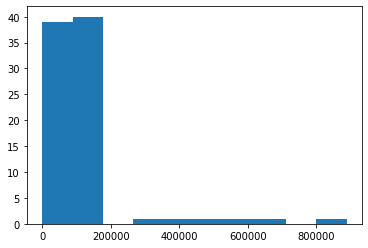

In [2]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
plt.hist(nasummary)


In [3]:
nasummary

AGER_TYP                685843
ALTERSKATEGORIE_GROB      2881
ANREDE_KZ                    0
CJT_GESAMTTYP             4854
FINANZ_MINIMALIST            0
                         ...  
PLZ8_HHZ                116515
PLZ8_GBZ                116515
ARBEIT                   97375
ORTSGR_KLS9              97274
RELAT_AB                 97375
Length: 85, dtype: int64

In [4]:
azdias.shape

(891221, 85)

(array([39., 40.,  0.,  1.,  1.,  1.,  1.,  1.,  0.,  1.]),
 array([ 0.        ,  9.97576359, 19.95152717, 29.92729076, 39.90305435,
        49.87881794, 59.85458152, 69.83034511, 79.8061087 , 89.78187229,
        99.75763587]),
 <BarContainer object of 10 artists>)

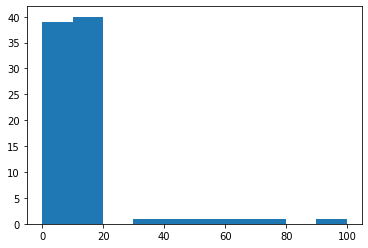

In [7]:
# Distribution of the percentages of missing values in each column
plt.hist(nasummary/891221*100)

In [12]:
nasummary[(nasummary/891221*100)>21]/891221*100

AGER_TYP        76.955435
GEBURTSJAHR     44.020282
TITEL_KZ        99.757636
ALTER_HH        34.813699
KK_KUNDENTYP    65.596749
KBA05_BAUMAX    53.468668
dtype: float64

As expected, the 6 outlier columns with more than 20% missing values are the very same ones as those with more than 200,000 missing values.

(array([31.,  1.,  0.,  0.,  7.,  9., 12., 10.,  6.,  3.]),
 array([     0. ,  15806.4,  31612.8,  47419.2,  63225.6,  79032. ,
         94838.4, 110644.8, 126451.2, 142257.6, 158064. ]),
 <BarContainer object of 10 artists>)

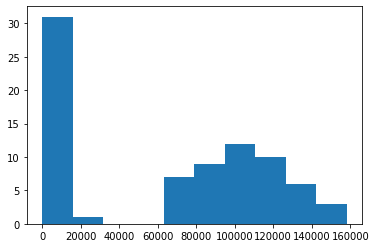

In [17]:
plt.hist(nasummary[nasummary<200000])

I will define the outlier columns as having more than 200,000 missing values.

As an alternative option, I also plotted a histogram only including columns with less than 200,000 missing values to find the almost-normal distribution right above this cell and will apply the empirical rule to treat all columns more than three standard deviations above the mean of this trimmed set as outliers.

In [18]:
# setting up variables for an alternative definition of outliers (more than three standard deviations away from the mean)
nasummary.describe()

count        85.000000
mean      98512.423529
std      146604.183603
min           0.000000
25%           0.000000
50%       93148.000000
75%      116515.000000
max      889061.000000
dtype: float64

In [19]:
three_sigma_column = nasummary.describe()['mean']+nasummary.describe()['std']*3
three_sigma_column

538324.9743373122

In [20]:
# Investigate patterns in the amount of missing data in each column.
nasummary.value_counts()


0         24
116515     7
133324     6
4854       6
93148      4
          ..
108315     1
94572      1
97632      1
392318     1
97274      1
Length: 32, dtype: int64

In [21]:
?azdias.drop

In [22]:
nasummary[nasummary>200000].index

Index(['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP',
       'KBA05_BAUMAX'],
      dtype='object')

In [23]:
# outlier columns using the standard outlier threshold of three standard deviations away from the mean
nasummary[nasummary>three_sigma_column].index

Index(['AGER_TYP', 'TITEL_KZ', 'KK_KUNDENTYP'], dtype='object')

In [24]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
trimmed = azdias.drop(columns=[i for i in azdias[nasummary[nasummary>200000].index]])
trimmed

ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  FINANZ_MINIMALIST  \
0                        2.0          1            2.0                  3   
1                        1.0          2            5.0                  1   
2                        3.0          2            3.0                  1   
3                        4.0          2            2.0                  4   
4                        3.0          1            5.0                  4   
...                      ...        ...            ...                ...   
891216                   3.0          2            5.0                  1   
891217                   2.0          1            4.0                  3   
891218                   2.0          2            4.0                  2   
891219                   1.0          1            3.0                  1   
891220                   4.0          1            1.0                  4   

        FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                   4                 3               5   
1                   5                 2               5   
2                   4                 1               2   
3                   2                 5               2   
4                   3                 4               1   
...               ...               ...             ...   
891216              4                 2               5   
891217              3                 3               2   
891218              4                 2               5   
891219              5                 3               5   
891220              2                 5               2   

        FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  FINANZTYP  ...  PLZ8_ANTG1  \
0                           5                 3          4  ...         NaN   
1                           4                 5          1  ...         2.0   
2                           3                 5          1  ...         3.0   
3                           1                 2          6  ...         2.0   
4                           3                 2          5  ...         2.0   
...                       ...               ...        ...  ...         ...   
891216                      4                 4          1  ...         3.0   
891217                      2                 3          6  ...         1.0   
891218                      4                 3          1  ...         4.0   
891219                      5                 5          1  ...         1.0   
891220                      1                 5          6  ...         3.0   

        PLZ8_ANTG2  PLZ8_ANTG3  PLZ8_ANTG4  PLZ8_BAUMAX  PLZ8_HHZ  PLZ8_GBZ  \
0              NaN         NaN         NaN          NaN       NaN       NaN   
1              3.0         2.0         1.0          1.0       5.0       4.0   
2              3.0         1.0         0.0          1.0       4.0       4.0   
3              2.0         2.0         0.0          1.0       3.0       4.0   
4              4.0         2.0         1.0          2.0       3.0       3.0   
...            ...         ...         ...          ...       ...       ...   
891216         2.0         0.0         0.0          1.0       2.0       3.0   
891217         3.0         3.0         2.0          4.0       5.0       3.0   
891218         2.0         0.0         0.0          1.0       3.0       4.0   
891219         4.0         3.0         1.0          5.0       1.0       1.0   
891220         3.0         1.0         0.0          1.0       4.0       4.0   

        ARBEIT  ORTSGR_KLS9  RELAT_AB  
0          NaN          NaN       NaN  
1          3.0          5.0       4.0  
2          3.0          5.0       2.0  
3          2.0          3.0       3.0  
4          4.0          6.0       5.0  
...        ...          ...       ...  
891216     NaN          NaN       NaN  
891217     4.0          6.0       5.0  
891218     2.0          2.0       3.0  
891219     4.0          7.0       5.0  
891220     3.0          4.0       5.

In [25]:
trimmed.head(10)

ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  FINANZ_MINIMALIST  \
0                   2.0          1            2.0                  3   
1                   1.0          2            5.0                  1   
2                   3.0          2            3.0                  1   
3                   4.0          2            2.0                  4   
4                   3.0          1            5.0                  4   
5                   1.0          2            2.0                  3   
6                   2.0          2            5.0                  1   
7                   1.0          1            3.0                  3   
8                   3.0          1            3.0                  4   
9                   3.0          2            4.0                  2   

   FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  \
0              4                 3               5                      5   
1              5                 2               5                      4   
2              4                 1               2                      3   
3              2                 5               2                      1   
4              3                 4               1                      3   
5              1                 5               2                      2   
6              5                 1               5                      4   
7              3                 4               1                      3   
8              4                 2               4                      2   
9              4                 2               3                      5   

   FINANZ_HAUSBAUER  FINANZTYP  ...  PLZ8_ANTG1  PLZ8_ANTG2  PLZ8_ANTG3  \
0                 3          4  ...         NaN         NaN         NaN   
1                 5          1  ...         2.0         3.0         2.0   
2                 5          1  ...         3.0         3.0         1.0   
3                 2          6  ...         2.0         2.0         2.0   
4                 2          5  ...         2.0         4.0         2.0   
5                 5          2  ...         2.0         3.0         1.0   
6                 3          4  ...         3.0         3.0         1.0   
7                 2          5  ...         3.0         3.0         1.0   
8                 2          6  ...         2.0         3.0         2.0   
9                 4          1  ...         2.0         3.0         2.0   

   PLZ8_ANTG4  PLZ8_BAUMAX  PLZ8_HHZ  PLZ8_GBZ  ARBEIT  ORTSGR_KLS9  RELAT_AB  
0         NaN          NaN       NaN       NaN     NaN          NaN       NaN  
1         1.0          1.0       5.0       4.0     3.0          5.0       4.0  
2         0.0          1.0       4.0       4.0     3.0          5.0       2.0  
3         0.0          1.0       3.0       4.0     2.0          3.0       3.0  
4         1.0          2.0       3.0       3.0     4.0          6.0       5.0  
5         1.0          1.0       5.0       5.0     2.0          3.0       3.0  
6         0.0          1.0       5.0       5.0     4.0          6.0       3.0  
7         0.0          1.0       4.0       4.0     2.0          5.0       2.0  
8         1.0          1.0       3.0       3.0     2.0          4.0       3.0  
9         1.0          1.0       3.0       3.0     2.0          3.0       1.0  

[10 rows x 79 columns]

In [26]:
dropped=[i for i in azdias[nasummary[nasummary>200000].index]]
dropped

['AGER_TYP',
 'GEBURTSJAHR',
 'TITEL_KZ',
 'ALTER_HH',
 'KK_KUNDENTYP',
 'KBA05_BAUMAX']

In [27]:
alt_trim=azdias.drop(columns=[i for i in azdias[nasummary[nasummary>np.floor(three_sigma_column)].index]])
alt_trim

ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  FINANZ_MINIMALIST  \
0                        2.0          1            2.0                  3   
1                        1.0          2            5.0                  1   
2                        3.0          2            3.0                  1   
3                        4.0          2            2.0                  4   
4                        3.0          1            5.0                  4   
...                      ...        ...            ...                ...   
891216                   3.0          2            5.0                  1   
891217                   2.0          1            4.0                  3   
891218                   2.0          2            4.0                  2   
891219                   1.0          1            3.0                  1   
891220                   4.0          1            1.0                  4   

        FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                   4                 3               5   
1                   5                 2               5   
2                   4                 1               2   
3                   2                 5               2   
4                   3                 4               1   
...               ...               ...             ...   
891216              4                 2               5   
891217              3                 3               2   
891218              4                 2               5   
891219              5                 3               5   
891220              2                 5               2   

        FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  FINANZTYP  ...  PLZ8_ANTG1  \
0                           5                 3          4  ...         NaN   
1                           4                 5          1  ...         2.0   
2                           3                 5          1  ...         3.0   
3                           1                 2          6  ...         2.0   
4                           3                 2          5  ...         2.0   
...                       ...               ...        ...  ...         ...   
891216                      4                 4          1  ...         3.0   
891217                      2                 3          6  ...         1.0   
891218                      4                 3          1  ...         4.0   
891219                      5                 5          1  ...         1.0   
891220                      1                 5          6  ...         3.0   

        PLZ8_ANTG2  PLZ8_ANTG3  PLZ8_ANTG4  PLZ8_BAUMAX  PLZ8_HHZ  PLZ8_GBZ  \
0              NaN         NaN         NaN          NaN       NaN       NaN   
1              3.0         2.0         1.0          1.0       5.0       4.0   
2              3.0         1.0         0.0          1.0       4.0       4.0   
3              2.0         2.0         0.0          1.0       3.0       4.0   
4              4.0         2.0         1.0          2.0       3.0       3.0   
...            ...         ...         ...          ...       ...       ...   
891216         2.0         0.0         0.0          1.0       2.0       3.0   
891217         3.0         3.0         2.0          4.0       5.0       3.0   
891218         2.0         0.0         0.0          1.0       3.0       4.0   
891219         4.0         3.0         1.0          5.0       1.0       1.0   
891220         3.0         1.0         0.0          1.0       4.0       4.0   

        ARBEIT  ORTSGR_KLS9  RELAT_AB  
0          NaN          NaN       NaN  
1          3.0          5.0       4.0  
2          3.0          5.0       2.0  
3          2.0          3.0       3.0  
4          4.0          6.0       5.0  
...        ...          ...       ...  
891216     NaN          NaN       NaN  
891217     4.0          6.0       5.0  
891218     2.0          2.0       3.0  
891219     4.0          7.0       5.0  
891220     3.0          4.0       5.

In [28]:
alt_trim.head(10)

ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  FINANZ_MINIMALIST  \
0                   2.0          1            2.0                  3   
1                   1.0          2            5.0                  1   
2                   3.0          2            3.0                  1   
3                   4.0          2            2.0                  4   
4                   3.0          1            5.0                  4   
5                   1.0          2            2.0                  3   
6                   2.0          2            5.0                  1   
7                   1.0          1            3.0                  3   
8                   3.0          1            3.0                  4   
9                   3.0          2            4.0                  2   

   FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  \
0              4                 3               5                      5   
1              5                 2               5                      4   
2              4                 1               2                      3   
3              2                 5               2                      1   
4              3                 4               1                      3   
5              1                 5               2                      2   
6              5                 1               5                      4   
7              3                 4               1                      3   
8              4                 2               4                      2   
9              4                 2               3                      5   

   FINANZ_HAUSBAUER  FINANZTYP  ...  PLZ8_ANTG1  PLZ8_ANTG2  PLZ8_ANTG3  \
0                 3          4  ...         NaN         NaN         NaN   
1                 5          1  ...         2.0         3.0         2.0   
2                 5          1  ...         3.0         3.0         1.0   
3                 2          6  ...         2.0         2.0         2.0   
4                 2          5  ...         2.0         4.0         2.0   
5                 5          2  ...         2.0         3.0         1.0   
6                 3          4  ...         3.0         3.0         1.0   
7                 2          5  ...         3.0         3.0         1.0   
8                 2          6  ...         2.0         3.0         2.0   
9                 4          1  ...         2.0         3.0         2.0   

   PLZ8_ANTG4  PLZ8_BAUMAX  PLZ8_HHZ  PLZ8_GBZ  ARBEIT  ORTSGR_KLS9  RELAT_AB  
0         NaN          NaN       NaN       NaN     NaN          NaN       NaN  
1         1.0          1.0       5.0       4.0     3.0          5.0       4.0  
2         0.0          1.0       4.0       4.0     3.0          5.0       2.0  
3         0.0          1.0       3.0       4.0     2.0          3.0       3.0  
4         1.0          2.0       3.0       3.0     4.0          6.0       5.0  
5         1.0          1.0       5.0       5.0     2.0          3.0       3.0  
6         0.0          1.0       5.0       5.0     4.0          6.0       3.0  
7         0.0          1.0       4.0       4.0     2.0          5.0       2.0  
8         1.0          1.0       3.0       3.0     2.0          4.0       3.0  
9         1.0          1.0       3.0       3.0     2.0          3.0       1.0  

[10 rows x 82 columns]

In [29]:
alt_dropped=[i for i in azdias[nasummary[nasummary>np.floor(three_sigma_column)].index]]
alt_dropped

['AGER_TYP', 'TITEL_KZ', 'KK_KUNDENTYP']

In [30]:
nasummary[nasummary.index.isin(dropped)]

AGER_TYP        685843
GEBURTSJAHR     392318
TITEL_KZ        889061
ALTER_HH        310267
KK_KUNDENTYP    584612
KBA05_BAUMAX    476524
dtype: int64

In [31]:
nasummary[nasummary.index.isin(alt_dropped)]

AGER_TYP        685843
TITEL_KZ        889061
KK_KUNDENTYP    584612
dtype: int64

In [32]:
pd.set_option('display.max_rows', None)
print(nasummary)
pd.set_option('display.max_rows', 10)

AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
SEMIO_ERL                     0
SEMIO_KU

In [33]:
pd.set_option('display.max_rows', None)
for i in dropped:
    print(azdias[azdias.notna()][i].value_counts())
    print("NaNs in " + i + ": " + str(azdias[i].isna().sum()))
pd.set_option('display.max_rows', 10)

2.0    98472
1.0    79802
3.0    27104
Name: AGER_TYP, dtype: int64
NaNs in AGER_TYP: 685843
1967.0    11183
1965.0    11090
1966.0    10933
1970.0    10883
1964.0    10799
1968.0    10792
1963.0    10513
1969.0    10360
1980.0    10275
1962.0    10082
1961.0     9880
1971.0     9786
1982.0     9516
1978.0     9509
1960.0     9492
1979.0     9422
1981.0     9374
1977.0     9296
1959.0     9098
1972.0     9027
1976.0     9005
1983.0     8887
1974.0     8676
1984.0     8553
1975.0     8480
1973.0     8356
1958.0     8323
1986.0     8192
1985.0     8180
1957.0     8099
1956.0     8039
1955.0     7828
1988.0     7801
1987.0     7767
1954.0     7533
1989.0     7251
1952.0     7106
1953.0     7096
1950.0     7071
1990.0     6848
1951.0     6832
1949.0     6657
1941.0     6235
1948.0     5833
1991.0     5741
1944.0     5493
1947.0     5475
1943.0     5442
1942.0     5222
1992.0     5200
1946.0     4808
1993.0     4635
1940.0     4561
1994.0     4249
1939.0     4226
1945.0     4113
1996.0     

In [34]:
to_drop = ["AGER_TYP","TITEL_KZ"]
col_trim = azdias.drop(columns=[i for i in azdias[to_drop]])
col_trim

ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  FINANZ_MINIMALIST  \
0                        2.0          1            2.0                  3   
1                        1.0          2            5.0                  1   
2                        3.0          2            3.0                  1   
3                        4.0          2            2.0                  4   
4                        3.0          1            5.0                  4   
...                      ...        ...            ...                ...   
891216                   3.0          2            5.0                  1   
891217                   2.0          1            4.0                  3   
891218                   2.0          2            4.0                  2   
891219                   1.0          1            3.0                  1   
891220                   4.0          1            1.0                  4   

        FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                   4                 3               5   
1                   5                 2               5   
2                   4                 1               2   
3                   2                 5               2   
4                   3                 4               1   
...               ...               ...             ...   
891216              4                 2               5   
891217              3                 3               2   
891218              4                 2               5   
891219              5                 3               5   
891220              2                 5               2   

        FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  FINANZTYP  ...  PLZ8_ANTG1  \
0                           5                 3          4  ...         NaN   
1                           4                 5          1  ...         2.0   
2                           3                 5          1  ...         3.0   
3                           1                 2          6  ...         2.0   
4                           3                 2          5  ...         2.0   
...                       ...               ...        ...  ...         ...   
891216                      4                 4          1  ...         3.0   
891217                      2                 3          6  ...         1.0   
891218                      4                 3          1  ...         4.0   
891219                      5                 5          1  ...         1.0   
891220                      1                 5          6  ...         3.0   

        PLZ8_ANTG2  PLZ8_ANTG3  PLZ8_ANTG4  PLZ8_BAUMAX  PLZ8_HHZ  PLZ8_GBZ  \
0              NaN         NaN         NaN          NaN       NaN       NaN   
1              3.0         2.0         1.0          1.0       5.0       4.0   
2              3.0         1.0         0.0          1.0       4.0       4.0   
3              2.0         2.0         0.0          1.0       3.0       4.0   
4              4.0         2.0         1.0          2.0       3.0       3.0   
...            ...         ...         ...          ...       ...       ...   
891216         2.0         0.0         0.0          1.0       2.0       3.0   
891217         3.0         3.0         2.0          4.0       5.0       3.0   
891218         2.0         0.0         0.0          1.0       3.0       4.0   
891219         4.0         3.0         1.0          5.0       1.0       1.0   
891220         3.0         1.0         0.0          1.0       4.0       4.0   

        ARBEIT  ORTSGR_KLS9  RELAT_AB  
0          NaN          NaN       NaN  
1          3.0          5.0       4.0  
2          3.0          5.0       2.0  
3          2.0          3.0       3.0  
4          4.0          6.0       5.0  
...        ...          ...       ...  
891216     NaN          NaN       NaN  
891217     4.0          6.0       5.0  
891218     2.0          2.0       3.0  
891219     4.0          7.0       5.0  
891220     3.0          4.0       5.

#### Discussion 1.1.2: Assess Missing Data in Each Column

None of the features that could be one-hot encoded had anywhere near the outlier count cutoff, but for any NaNs those features had, all the resulting dummy variables will also be NaN, which may lead to some rows not being particularly useful if a lot of these features had missing values in the same row.

I decided to use the empirical rule outlier cutoff of three standard deviations above the mean in number of missing values because I felt the gap between the empirical outliers and those with more than 200,000 missing values was significant enough to only consider dropping the empirical outliers.

The ager typology AGER_TYP, consumer pattern KK_KUNDENTYP, and academic title flag TITEL_KZ columns each contain more than 50% missing values.

I believe AGER_TYP is also a bit of a redundant and overly specific feature since all its non-missing labels have to do with the elderly, and that GEBURTSJAHR is a better feature to focus on with regards to age, so I dropped AGER_TYP.

TITEL_KZ contains about 99.76% missing values, so I dropped it due to the lack of enough useful information.

KK_KUNDENTYP contains about 65.6% missing values but I decided to keep it for now because I feel it could still be potentially useful.

KBA05_BAUMAX was not flagged with this cutoff, but it was close enough that I decided to drop it as well.

In [35]:
final_drops = ["AGER_TYP", "TITEL_KZ", "KBA05_BAUMAX"]

In [36]:
final_trim = azdias.drop(columns=final_drops)
final_trim

ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  FINANZ_MINIMALIST  \
0                        2.0          1            2.0                  3   
1                        1.0          2            5.0                  1   
2                        3.0          2            3.0                  1   
3                        4.0          2            2.0                  4   
4                        3.0          1            5.0                  4   
...                      ...        ...            ...                ...   
891216                   3.0          2            5.0                  1   
891217                   2.0          1            4.0                  3   
891218                   2.0          2            4.0                  2   
891219                   1.0          1            3.0                  1   
891220                   4.0          1            1.0                  4   

        FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                   4                 3               5   
1                   5                 2               5   
2                   4                 1               2   
3                   2                 5               2   
4                   3                 4               1   
...               ...               ...             ...   
891216              4                 2               5   
891217              3                 3               2   
891218              4                 2               5   
891219              5                 3               5   
891220              2                 5               2   

        FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  FINANZTYP  ...  PLZ8_ANTG1  \
0                           5                 3          4  ...         NaN   
1                           4                 5          1  ...         2.0   
2                           3                 5          1  ...         3.0   
3                           1                 2          6  ...         2.0   
4                           3                 2          5  ...         2.0   
...                       ...               ...        ...  ...         ...   
891216                      4                 4          1  ...         3.0   
891217                      2                 3          6  ...         1.0   
891218                      4                 3          1  ...         4.0   
891219                      5                 5          1  ...         1.0   
891220                      1                 5          6  ...         3.0   

        PLZ8_ANTG2  PLZ8_ANTG3  PLZ8_ANTG4  PLZ8_BAUMAX  PLZ8_HHZ  PLZ8_GBZ  \
0              NaN         NaN         NaN          NaN       NaN       NaN   
1              3.0         2.0         1.0          1.0       5.0       4.0   
2              3.0         1.0         0.0          1.0       4.0       4.0   
3              2.0         2.0         0.0          1.0       3.0       4.0   
4              4.0         2.0         1.0          2.0       3.0       3.0   
...            ...         ...         ...          ...       ...       ...   
891216         2.0         0.0         0.0          1.0       2.0       3.0   
891217         3.0         3.0         2.0          4.0       5.0       3.0   
891218         2.0         0.0         0.0          1.0       3.0       4.0   
891219         4.0         3.0         1.0          5.0       1.0       1.0   
891220         3.0         1.0         0.0          1.0       4.0       4.0   

        ARBEIT  ORTSGR_KLS9  RELAT_AB  
0          NaN          NaN       NaN  
1          3.0          5.0       4.0  
2          3.0          5.0       2.0  
3          2.0          3.0       3.0  
4          4.0          6.0       5.0  
...        ...          ...       ...  
891216     NaN          NaN       NaN  
891217     4.0          6.0       5.0  
891218     2.0          2.0       3.0  
891219     4.0          7.0       5.0  
891220     3.0          4.0       5.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [37]:
# How much data is missing in each row of the dataset?
row_nasummary = final_trim.isna().sum(1)
row_nasummary

0         46
1          2
2          1
3          8
4          0
          ..
891216     3
891217     5
891218     6
891219     2
891220     3
Length: 891221, dtype: int64

In [38]:
alt_nasummary = final_trim.isna().sum(1)
alt_nasummary

0         46
1          2
2          1
3          8
4          0
          ..
891216     3
891217     5
891218     6
891219     2
891220     3
Length: 891221, dtype: int64

(array([6.91362e+05, 7.30650e+04, 2.41340e+04, 8.14300e+03, 1.13300e+03,
        2.17000e+02, 1.07140e+04, 8.22000e+03, 7.02000e+02, 7.35310e+04]),
 array([ 0. ,  5.1, 10.2, 15.3, 20.4, 25.5, 30.6, 35.7, 40.8, 45.9, 51. ]),
 <BarContainer object of 10 artists>)

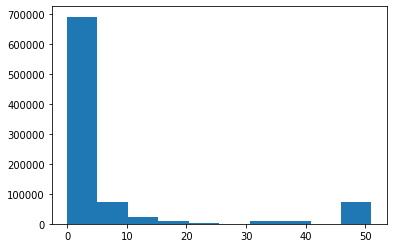

In [39]:
plt.hist(row_nasummary)

I will define the outlier rows as having more than 20 missing values.

As an alternative, I have also set up variables that allow me to treat all values that are more than three standard deviations away from the mean as outliers (i.e. following the empirical rule).

(array([6.91362e+05, 7.30650e+04, 2.41340e+04, 8.14300e+03, 1.13300e+03,
        2.17000e+02, 1.07140e+04, 8.22000e+03, 7.02000e+02, 7.35310e+04]),
 array([ 0. ,  5.1, 10.2, 15.3, 20.4, 25.5, 30.6, 35.7, 40.8, 45.9, 51. ]),
 <BarContainer object of 10 artists>)

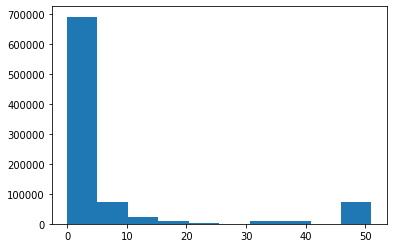

In [40]:
plt.hist(alt_nasummary)

(array([172554., 230513., 120224., 132960.,  21213.,  13898.,  23418.,
          9749.,  17312.,  22586.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <BarContainer object of 10 artists>)

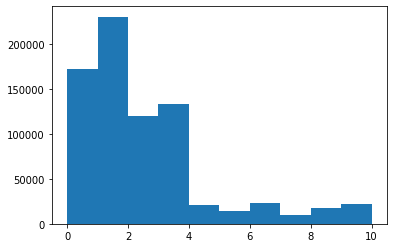

In [41]:
plt.hist(alt_nasummary[alt_nasummary <= 10])

In [42]:
outlier_rows = row_nasummary[row_nasummary>20].index
non_outlier_rows = row_nasummary[row_nasummary<=20].index
outlier_rows

Int64Index([     0,     11,     14,     17,     24,     26,     30,     35,
                46,     48,
            ...
            891137, 891140, 891159, 891164, 891169, 891171, 891173, 891175,
            891185, 891187],
           dtype='int64', length=94517)

In [43]:
three_sigma_row = alt_nasummary.describe()['std']*3
three_sigma_row

41.12893579416597

In [44]:
alt_nasummary.describe()['mean'] + three_sigma_row

48.22271836885844

Due to the very long tail at the right of the full alt_nasummary distribution, I have "zoomed in" and trimmed everything with more than 10 missing values to see if the distribution looks closer to normal. It was still fairly skewed, but a somewhat better fit for the empirical rule.

In [45]:
trim_three_sigma_row = alt_nasummary[alt_nasummary <= 10].describe()['std']*3
trim_three_sigma_row

6.667526798354475

In [46]:
alt_nasummary[alt_nasummary <= 10].describe()['mean'] + trim_three_sigma_row

8.742174868085137

In [47]:
# outlier rows using the empirical outlier threshold of three standard deviations above the mean
emp_outliers = alt_nasummary[alt_nasummary>(alt_nasummary.describe()['mean']+trim_three_sigma_row)].index
emp_outliers.append(alt_nasummary[alt_nasummary<(alt_nasummary.describe()['mean']-trim_three_sigma_row)]
                    .index).sort_values(ascending=True)

emp_non_outliers = alt_nasummary[alt_nasummary<=(alt_nasummary.describe()['mean']+trim_three_sigma_row)].index
emp_non_outliers.append(alt_nasummary[alt_nasummary>=(alt_nasummary.describe()['mean']-trim_three_sigma_row)]
                        .index).sort_values(ascending=True)

emp_outliers

Int64Index([     0,     11,     14,     17,     24,     26,     30,     35,
                46,     48,
            ...
            891164, 891169, 891170, 891171, 891172, 891173, 891175, 891185,
            891187, 891203],
           dtype='int64', length=108564)

In [48]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
above_threshold = final_trim.iloc[outlier_rows,:]
above_threshold

ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  FINANZ_MINIMALIST  \
0                        2.0          1            2.0                  3   
11                       2.0          1            6.0                  3   
14                       3.0          1            6.0                  3   
17                       2.0          1            6.0                  3   
24                       3.0          2            6.0                  3   
...                      ...        ...            ...                ...   
891171                   3.0          2            5.0                  4   
891173                   4.0          1            1.0                  4   
891175                   3.0          2            6.0                  3   
891185                   3.0          1            6.0                  3   
891187                   3.0          2            6.0                  3   

        FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                   4                 3               5   
11                  4                 3               5   
14                  4                 3               5   
17                  4                 3               5   
24                  4                 3               5   
...               ...               ...             ...   
891171              2                 3               5   
891173              1                 5               1   
891175              4                 3               5   
891185              4                 3               5   
891187              4                 3               5   

        FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  FINANZTYP  ...  PLZ8_ANTG1  \
0                           5                 3          4  ...         NaN   
11                          5                 3          4  ...         NaN   
14                          5                 3          4  ...         NaN   
17                          5                 3          4  ...         NaN   
24                          5                 3          4  ...         NaN   
...                       ...               ...        ...  ...         ...   
891171                      5                 1          3  ...         NaN   
891173                      2                 2          5  ...         NaN   
891175                      5                 3          4  ...         NaN   
891185                      5                 3          4  ...         NaN   
891187                      5                 3          4  ...         NaN   

        PLZ8_ANTG2  PLZ8_ANTG3  PLZ8_ANTG4  PLZ8_BAUMAX  PLZ8_HHZ  PLZ8_GBZ  \
0              NaN         NaN         NaN          NaN       NaN       NaN   
11             NaN         NaN         NaN          NaN       NaN       NaN   
14             NaN         NaN         NaN          NaN       NaN       NaN   
17             NaN         NaN         NaN          NaN       NaN       NaN   
24             NaN         NaN         NaN          NaN       NaN       NaN   
...            ...         ...         ...          ...       ...       ...   
891171         NaN         NaN         NaN          NaN       NaN       NaN   
891173         NaN         NaN         NaN          NaN       NaN       NaN   
891175         NaN         NaN         NaN          NaN       NaN       NaN   
891185         NaN         NaN         NaN          NaN       NaN       NaN   
891187         NaN         NaN         NaN          NaN       NaN       NaN   

        ARBEIT  ORTSGR_KLS9  RELAT_AB  
0          NaN          NaN       NaN  
11         NaN          NaN       NaN  
14         NaN          NaN       NaN  
17         NaN          NaN       NaN  
24         NaN          NaN       NaN  
...        ...          ...       ...  
891171     NaN          NaN       NaN  
891173     NaN          NaN       NaN  
891175     NaN          NaN       NaN  
891185     NaN          NaN       NaN  
891187     NaN          NaN       Na

In [49]:
emp_above = final_trim.iloc[emp_outliers,:]
emp_above

ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  FINANZ_MINIMALIST  \
0                        2.0          1            2.0                  3   
11                       2.0          1            6.0                  3   
14                       3.0          1            6.0                  3   
17                       2.0          1            6.0                  3   
24                       3.0          2            6.0                  3   
...                      ...        ...            ...                ...   
891173                   4.0          1            1.0                  4   
891175                   3.0          2            6.0                  3   
891185                   3.0          1            6.0                  3   
891187                   3.0          2            6.0                  3   
891203                   4.0          2            1.0                  4   

        FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                   4                 3               5   
11                  4                 3               5   
14                  4                 3               5   
17                  4                 3               5   
24                  4                 3               5   
...               ...               ...             ...   
891173              1                 5               1   
891175              4                 3               5   
891185              4                 3               5   
891187              4                 3               5   
891203              1                 5               1   

        FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  FINANZTYP  ...  PLZ8_ANTG1  \
0                           5                 3          4  ...         NaN   
11                          5                 3          4  ...         NaN   
14                          5                 3          4  ...         NaN   
17                          5                 3          4  ...         NaN   
24                          5                 3          4  ...         NaN   
...                       ...               ...        ...  ...         ...   
891173                      2                 2          5  ...         NaN   
891175                      5                 3          4  ...         NaN   
891185                      5                 3          4  ...         NaN   
891187                      5                 3          4  ...         NaN   
891203                      3                 4          5  ...         2.0   

        PLZ8_ANTG2  PLZ8_ANTG3  PLZ8_ANTG4  PLZ8_BAUMAX  PLZ8_HHZ  PLZ8_GBZ  \
0              NaN         NaN         NaN          NaN       NaN       NaN   
11             NaN         NaN         NaN          NaN       NaN       NaN   
14             NaN         NaN         NaN          NaN       NaN       NaN   
17             NaN         NaN         NaN          NaN       NaN       NaN   
24             NaN         NaN         NaN          NaN       NaN       NaN   
...            ...         ...         ...          ...       ...       ...   
891173         NaN         NaN         NaN          NaN       NaN       NaN   
891175         NaN         NaN         NaN          NaN       NaN       NaN   
891185         NaN         NaN         NaN          NaN       NaN       NaN   
891187         NaN         NaN         NaN          NaN       NaN       NaN   
891203         3.0         2.0         1.0          1.0       3.0       3.0   

        ARBEIT  ORTSGR_KLS9  RELAT_AB  
0          NaN          NaN       NaN  
11         NaN          NaN       NaN  
14         NaN          NaN       NaN  
17         NaN          NaN       NaN  
24         NaN          NaN       NaN  
...        ...          ...       ...  
891173     NaN          NaN       NaN  
891175     NaN          NaN       NaN  
891185     NaN          NaN       NaN  
891187     NaN          NaN       NaN  
891203     4.0          8.0       5.

In [50]:
below_threshold = final_trim.iloc[non_outlier_rows,:]
below_threshold

ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  FINANZ_MINIMALIST  \
1                        1.0          2            5.0                  1   
2                        3.0          2            3.0                  1   
3                        4.0          2            2.0                  4   
4                        3.0          1            5.0                  4   
5                        1.0          2            2.0                  3   
...                      ...        ...            ...                ...   
891216                   3.0          2            5.0                  1   
891217                   2.0          1            4.0                  3   
891218                   2.0          2            4.0                  2   
891219                   1.0          1            3.0                  1   
891220                   4.0          1            1.0                  4   

        FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
1                   5                 2               5   
2                   4                 1               2   
3                   2                 5               2   
4                   3                 4               1   
5                   1                 5               2   
...               ...               ...             ...   
891216              4                 2               5   
891217              3                 3               2   
891218              4                 2               5   
891219              5                 3               5   
891220              2                 5               2   

        FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  FINANZTYP  ...  PLZ8_ANTG1  \
1                           4                 5          1  ...         2.0   
2                           3                 5          1  ...         3.0   
3                           1                 2          6  ...         2.0   
4                           3                 2          5  ...         2.0   
5                           2                 5          2  ...         2.0   
...                       ...               ...        ...  ...         ...   
891216                      4                 4          1  ...         3.0   
891217                      2                 3          6  ...         1.0   
891218                      4                 3          1  ...         4.0   
891219                      5                 5          1  ...         1.0   
891220                      1                 5          6  ...         3.0   

        PLZ8_ANTG2  PLZ8_ANTG3  PLZ8_ANTG4  PLZ8_BAUMAX  PLZ8_HHZ  PLZ8_GBZ  \
1              3.0         2.0         1.0          1.0       5.0       4.0   
2              3.0         1.0         0.0          1.0       4.0       4.0   
3              2.0         2.0         0.0          1.0       3.0       4.0   
4              4.0         2.0         1.0          2.0       3.0       3.0   
5              3.0         1.0         1.0          1.0       5.0       5.0   
...            ...         ...         ...          ...       ...       ...   
891216         2.0         0.0         0.0          1.0       2.0       3.0   
891217         3.0         3.0         2.0          4.0       5.0       3.0   
891218         2.0         0.0         0.0          1.0       3.0       4.0   
891219         4.0         3.0         1.0          5.0       1.0       1.0   
891220         3.0         1.0         0.0          1.0       4.0       4.0   

        ARBEIT  ORTSGR_KLS9  RELAT_AB  
1          3.0          5.0       4.0  
2          3.0          5.0       2.0  
3          2.0          3.0       3.0  
4          4.0          6.0       5.0  
5          2.0          3.0       3.0  
...        ...          ...       ...  
891216     NaN          NaN       NaN  
891217     4.0          6.0       5.0  
891218     2.0          2.0       3.0  
891219     4.0          7.0       5.0  
891220     3.0          4.0       5.

In [51]:
emp_below = final_trim.iloc[emp_non_outliers,:]
emp_below

ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  FINANZ_MINIMALIST  \
1                        1.0          2            5.0                  1   
2                        3.0          2            3.0                  1   
3                        4.0          2            2.0                  4   
4                        3.0          1            5.0                  4   
5                        1.0          2            2.0                  3   
...                      ...        ...            ...                ...   
891216                   3.0          2            5.0                  1   
891217                   2.0          1            4.0                  3   
891218                   2.0          2            4.0                  2   
891219                   1.0          1            3.0                  1   
891220                   4.0          1            1.0                  4   

        FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
1                   5                 2               5   
2                   4                 1               2   
3                   2                 5               2   
4                   3                 4               1   
5                   1                 5               2   
...               ...               ...             ...   
891216              4                 2               5   
891217              3                 3               2   
891218              4                 2               5   
891219              5                 3               5   
891220              2                 5               2   

        FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  FINANZTYP  ...  PLZ8_ANTG1  \
1                           4                 5          1  ...         2.0   
2                           3                 5          1  ...         3.0   
3                           1                 2          6  ...         2.0   
4                           3                 2          5  ...         2.0   
5                           2                 5          2  ...         2.0   
...                       ...               ...        ...  ...         ...   
891216                      4                 4          1  ...         3.0   
891217                      2                 3          6  ...         1.0   
891218                      4                 3          1  ...         4.0   
891219                      5                 5          1  ...         1.0   
891220                      1                 5          6  ...         3.0   

        PLZ8_ANTG2  PLZ8_ANTG3  PLZ8_ANTG4  PLZ8_BAUMAX  PLZ8_HHZ  PLZ8_GBZ  \
1              3.0         2.0         1.0          1.0       5.0       4.0   
2              3.0         1.0         0.0          1.0       4.0       4.0   
3              2.0         2.0         0.0          1.0       3.0       4.0   
4              4.0         2.0         1.0          2.0       3.0       3.0   
5              3.0         1.0         1.0          1.0       5.0       5.0   
...            ...         ...         ...          ...       ...       ...   
891216         2.0         0.0         0.0          1.0       2.0       3.0   
891217         3.0         3.0         2.0          4.0       5.0       3.0   
891218         2.0         0.0         0.0          1.0       3.0       4.0   
891219         4.0         3.0         1.0          5.0       1.0       1.0   
891220         3.0         1.0         0.0          1.0       4.0       4.0   

        ARBEIT  ORTSGR_KLS9  RELAT_AB  
1          3.0          5.0       4.0  
2          3.0          5.0       2.0  
3          2.0          3.0       3.0  
4          4.0          6.0       5.0  
5          2.0          3.0       3.0  
...        ...          ...       ...  
891216     NaN          NaN       NaN  
891217     4.0          6.0       5.0  
891218     2.0          2.0       3.0  
891219     4.0          7.0       5.0  
891220     3.0          4.0       5.

(array([  881.,   336.,   114.,   135., 10598.,  7716.,   637.,   514.,
        27522., 46064.]),
 array([21., 24., 27., 30., 33., 36., 39., 42., 45., 48., 51.]),
 <BarContainer object of 10 artists>)

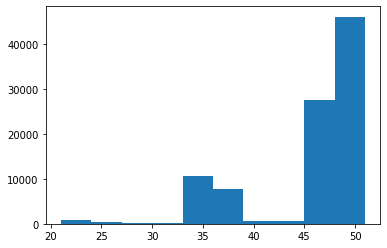

In [52]:
# checking the distribution of nans across rows to pick a threshold I think is reasonable for "few nans"

low_above_threshold = above_threshold.isna().sum(1).sort_values(ascending=True)

plt.hist(above_threshold.isna().sum(1))

(array([403067., 253184.,  35111.,  33167.,  28685.,  23948.,   5495.,
          5904.,   4942.,   3201.]),
 array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20.]),
 <BarContainer object of 10 artists>)

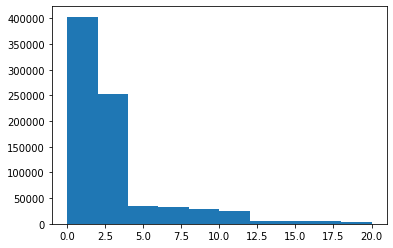

In [53]:
low_below_threshold = below_threshold.isna().sum(1).sort_values(ascending=True)

plt.hist(below_threshold.isna().sum(1))

In [54]:
below_threshold.isna().sum(1)

1         2
2         1
3         8
4         0
5         0
         ..
891216    3
891217    5
891218    6
891219    2
891220    3
Length: 796704, dtype: int64

(array([10846.,  3591.,   743.,   168.,   165., 13506.,  5129.,   511.,
        27841., 46064.]),
 array([14. , 17.7, 21.4, 25.1, 28.8, 32.5, 36.2, 39.9, 43.6, 47.3, 51. ]),
 <BarContainer object of 10 artists>)

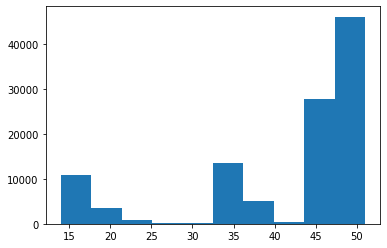

In [55]:
# doing the same with the empirical outlier cutoff

plt.hist(emp_above.isna().sum(1))

(array([403067., 120224., 132960.,  35111.,  23418.,   9749.,  28685.,
         11213.,  12735.,   5495.]),
 array([ 0. ,  1.3,  2.6,  3.9,  5.2,  6.5,  7.8,  9.1, 10.4, 11.7, 13. ]),
 <BarContainer object of 10 artists>)

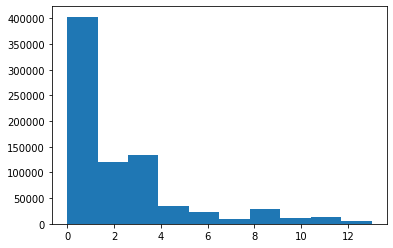

In [56]:
plt.hist(emp_below.isna().sum(1))

I think a reasonable cutoff for having "few missing values" would be for a row to have no more than 5 in both the manual and empirical cases. With 79 columns to a row, that would mean having no more than approximately 6.3% missing values.

- ## Compare the distribution of values for at least five columns where there are no or few missing values, between the two subsets:

(array([32., 38.,  9.,  0.,  0.,  1.,  1.,  0.,  0.,  1.]),
 array([     0. ,  58461.2, 116922.4, 175383.6, 233844.8, 292306. ,
        350767.2, 409228.4, 467689.6, 526150.8, 584612. ]),
 <BarContainer object of 10 artists>)

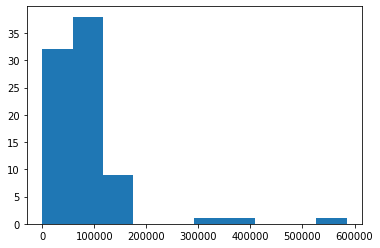

In [57]:
# Setting a cutoff for what "few" means:
trim_na = final_trim.isna().sum()
plt.hist(trim_na)

In [58]:
trim_na.sort_values(ascending=True)[trim_na>=4854].head(10)

LP_STATUS_GROB         4854
LP_STATUS_FEIN         4854
ONLINE_AFFINITAET      4854
GFK_URLAUBERTYP        4854
RETOURTYP_BK_S         4854
CJT_GESAMTTYP          4854
HH_EINKOMMEN_SCORE    18348
WOHNDAUER_2008        73499
SOHO_KZ               73499
ANZ_TITEL             73499
dtype: int64

- Since there's a huge gap in the histogram after HH_EINKOMMEN_SCORE at 18348, I think a reasonable cutoff for "few" missing values would be 20,000 since it's a friendlier number to write down and talk about than 18348 while still fulfilling the same purpose as a cutoff.

(array([32., 38.,  9.,  0.,  0.,  1.,  1.,  0.,  0.,  1.]),
 array([     0. ,  58461.2, 116922.4, 175383.6, 233844.8, 292306. ,
        350767.2, 409228.4, 467689.6, 526150.8, 584612. ]),
 <BarContainer object of 10 artists>)

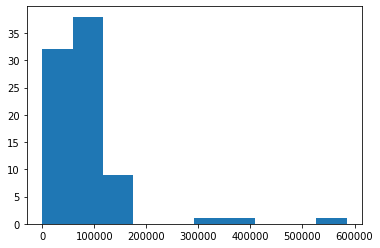

In [59]:
alt_na = final_trim.isna().sum()
plt.hist(alt_na)

In [60]:
alt_na.sort_values(ascending=True)[alt_na>=4854].head(10)

LP_STATUS_GROB         4854
LP_STATUS_FEIN         4854
ONLINE_AFFINITAET      4854
GFK_URLAUBERTYP        4854
RETOURTYP_BK_S         4854
CJT_GESAMTTYP          4854
HH_EINKOMMEN_SCORE    18348
WOHNDAUER_2008        73499
SOHO_KZ               73499
ANZ_TITEL             73499
dtype: int64

In [61]:
alt_na.describe()

count        82.000000
mean      77099.121951
std       89922.988388
min           0.000000
25%           0.000000
50%       93148.000000
75%      111196.000000
max      584612.000000
dtype: float64

(array([31.,  1.,  0.,  0.,  7.,  9., 12., 10.,  6.,  3.]),
 array([     0. ,  15806.4,  31612.8,  47419.2,  63225.6,  79032. ,
         94838.4, 110644.8, 126451.2, 142257.6, 158064. ]),
 <BarContainer object of 10 artists>)

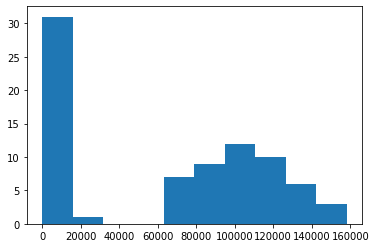

In [62]:
trim_alt_na = alt_na[alt_na < 200000]
plt.hist(trim_alt_na)

In [63]:
trim_alt_na.describe()

count        79.000000
mean      63733.303797
std       54250.743440
min           0.000000
25%           0.000000
50%       93148.000000
75%      108239.500000
max      158064.000000
dtype: float64

In [64]:
trim_alt_na.describe()['mean'] - trim_alt_na.describe()['std']

9482.5603573646

I believe that it would simply be better to also keep a "few" cutoff of 20,000 missing values with this method simply due to HH_EINKOMMEN_SCORE having a far closer missing value count to 4,854 than it does to 73,499 (namely, 18,348).

In [65]:
trim_na[trim_na<20000]

ALTERSKATEGORIE_GROB     2881
ANREDE_KZ                   0
CJT_GESAMTTYP            4854
FINANZ_MINIMALIST           0
FINANZ_SPARER               0
                        ...  
SEMIO_PFLICHT               0
SEMIO_TRADV                 0
ZABEOTYP                    0
HH_EINKOMMEN_SCORE      18348
ONLINE_AFFINITAET        4854
Length: 32, dtype: int64

In [66]:
few = list(trim_na[trim_na<20000].index)
few

['ALTERSKATEGORIE_GROB',
 'ANREDE_KZ',
 'CJT_GESAMTTYP',
 'FINANZ_MINIMALIST',
 'FINANZ_SPARER',
 'FINANZ_VORSORGER',
 'FINANZ_ANLEGER',
 'FINANZ_UNAUFFAELLIGER',
 'FINANZ_HAUSBAUER',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'GREEN_AVANTGARDE',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'RETOURTYP_BK_S',
 'SEMIO_SOZ',
 'SEMIO_FAM',
 'SEMIO_REL',
 'SEMIO_MAT',
 'SEMIO_VERT',
 'SEMIO_LUST',
 'SEMIO_ERL',
 'SEMIO_KULT',
 'SEMIO_RAT',
 'SEMIO_KRIT',
 'SEMIO_DOM',
 'SEMIO_KAEM',
 'SEMIO_PFLICHT',
 'SEMIO_TRADV',
 'ZABEOTYP',
 'HH_EINKOMMEN_SCORE',
 'ONLINE_AFFINITAET']

In [67]:
few_alt = list(alt_na[alt_na<20000].index)
few_alt

['ALTERSKATEGORIE_GROB',
 'ANREDE_KZ',
 'CJT_GESAMTTYP',
 'FINANZ_MINIMALIST',
 'FINANZ_SPARER',
 'FINANZ_VORSORGER',
 'FINANZ_ANLEGER',
 'FINANZ_UNAUFFAELLIGER',
 'FINANZ_HAUSBAUER',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'GREEN_AVANTGARDE',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'RETOURTYP_BK_S',
 'SEMIO_SOZ',
 'SEMIO_FAM',
 'SEMIO_REL',
 'SEMIO_MAT',
 'SEMIO_VERT',
 'SEMIO_LUST',
 'SEMIO_ERL',
 'SEMIO_KULT',
 'SEMIO_RAT',
 'SEMIO_KRIT',
 'SEMIO_DOM',
 'SEMIO_KAEM',
 'SEMIO_PFLICHT',
 'SEMIO_TRADV',
 'ZABEOTYP',
 'HH_EINKOMMEN_SCORE',
 'ONLINE_AFFINITAET']

In [68]:
few == few_alt

True

In [69]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
# randomly selecting n columns that have less than 600 missing values
import random as rand
rand.seed(42)
n = 10
random_columns = [few[rand.randint(0, len(few)-1)] for i in range(0,n)]
random_columns

['FINANZ_UNAUFFAELLIGER',
 'ANREDE_KZ',
 'SEMIO_REL',
 'SEMIO_SOZ',
 'RETOURTYP_BK_S',
 'FINANZ_HAUSBAUER',
 'FINANZ_ANLEGER',
 'FINANZ_VORSORGER',
 'SEMIO_PFLICHT',
 'CJT_GESAMTTYP']

In [70]:
?sns.countplot

In [71]:
?plt.bar

C:\Users\mujta\AppData\Local\Temp/ipykernel_17812/1493427106.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


20 Missing Value Cutoff:


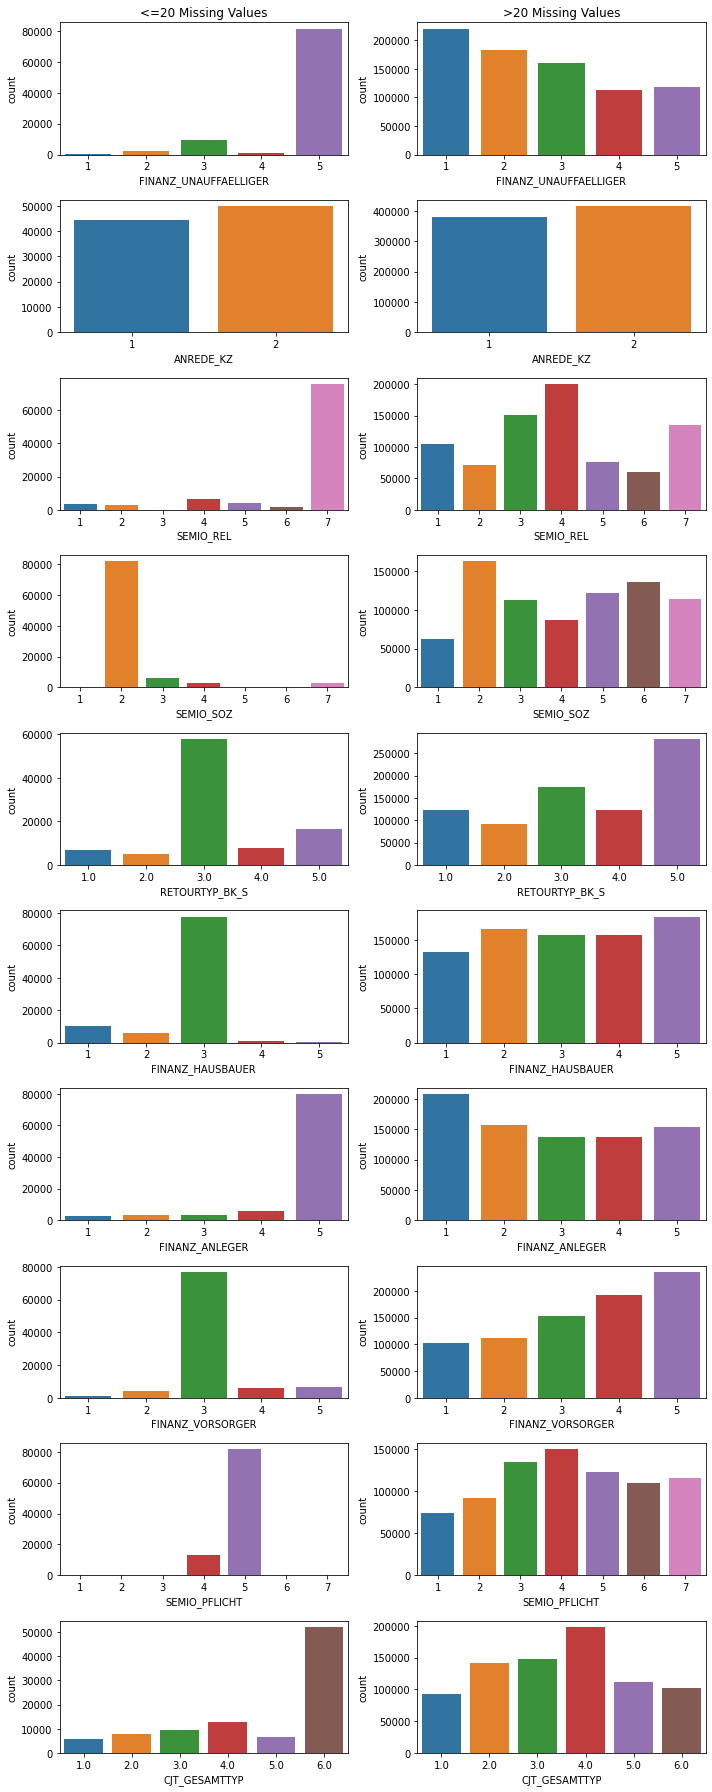

In [72]:
fig, axs = plt.subplots(n, 2, figsize=(10,2.5*n))
axs[0,0].set_title("<=20 Missing Values")
axs[0,1].set_title(">20 Missing Values")
for i in range(0, n):
    sns.countplot(x=above_threshold[random_columns[i]], ax=axs[i,0])
    sns.countplot(x=below_threshold[random_columns[i]], ax=axs[i,1])
plt.tight_layout()
fig.show()
print("20 Missing Value Cutoff:")

C:\Users\mujta\AppData\Local\Temp/ipykernel_17812/2585627065.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Empirical Rule Cutoff:


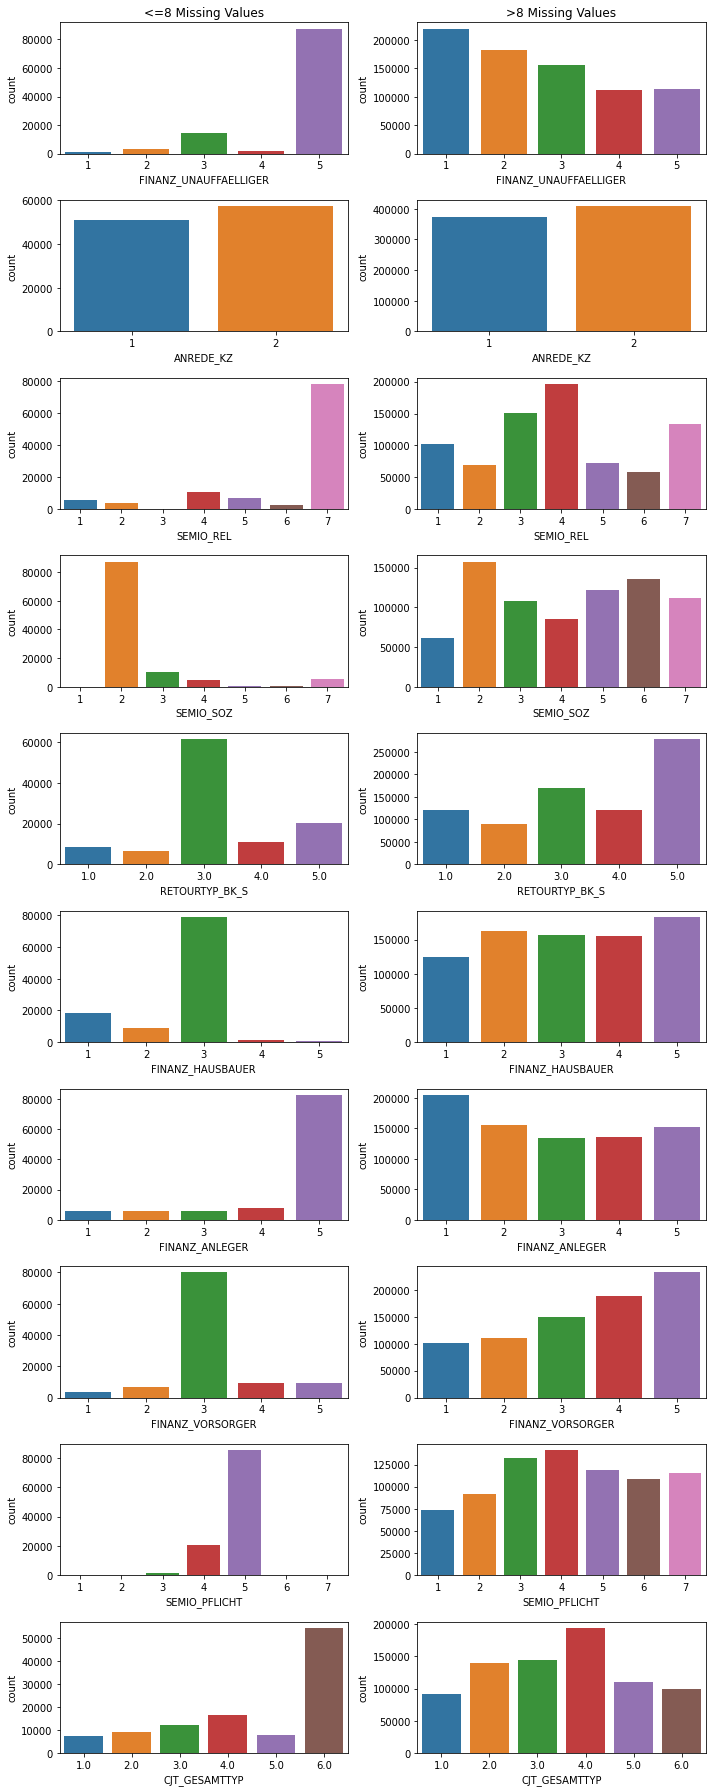

In [73]:
fig, axs = plt.subplots(n, 2, figsize=(10,2.5*n))
axs[0,0].set_title("<=8 Missing Values")
axs[0,1].set_title(">8 Missing Values")
for i in range(0, n):
    sns.countplot(x=emp_above[random_columns[i]], ax=axs[i,0])
    sns.countplot(x=emp_below[random_columns[i]], ax=axs[i,1])
plt.tight_layout()
fig.show()
print("Empirical Rule Cutoff:")

### Checking all columns just to be sure since there aren't a whole lot with my cutoffs:

C:\Users\mujta\AppData\Local\Temp/ipykernel_17812/2136150019.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


20 Missing Value Cutoff:


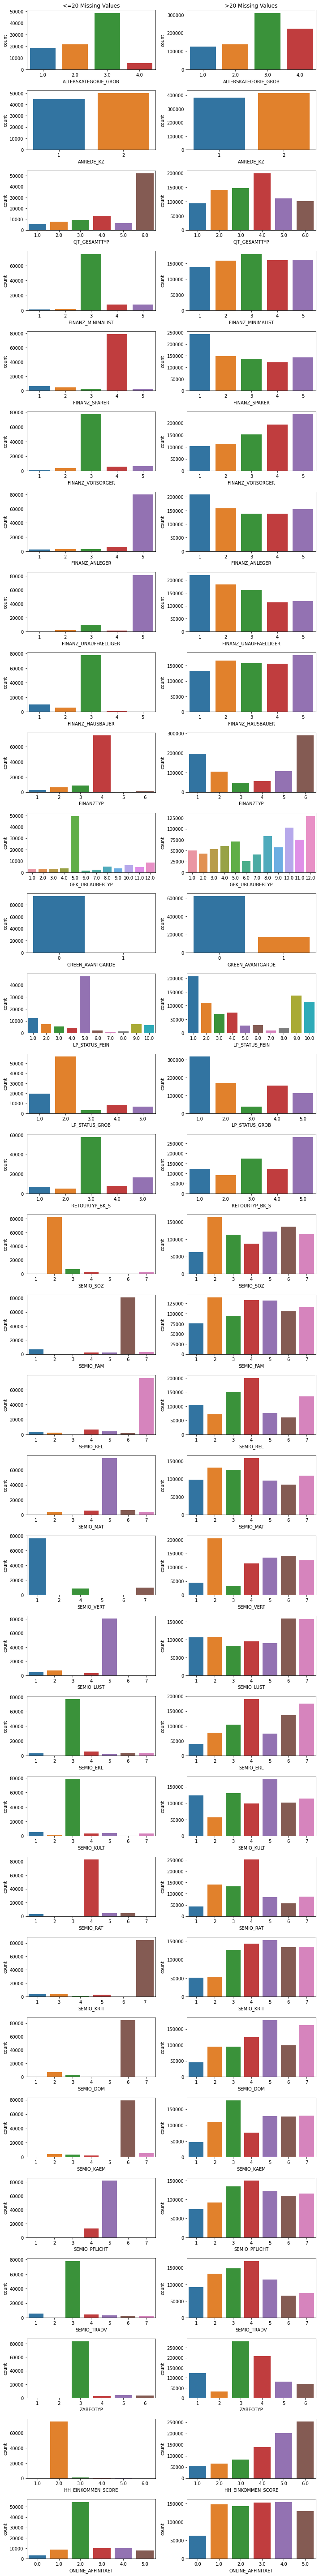

In [74]:
fig, axs = plt.subplots(len(few), 2, figsize=(10,2.5*len(few)))
axs[0,0].set_title("<=20 Missing Values")
axs[0,1].set_title(">20 Missing Values")
for i in range(0, len(few)):
    sns.countplot(x=above_threshold[few[i]], ax=axs[i,0])
    sns.countplot(x=below_threshold[few[i]], ax=axs[i,1])
plt.tight_layout()
fig.show()
print("20 Missing Value Cutoff:")

C:\Users\mujta\AppData\Local\Temp/ipykernel_17812/3617136687.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Empirical Rule Cutoff:


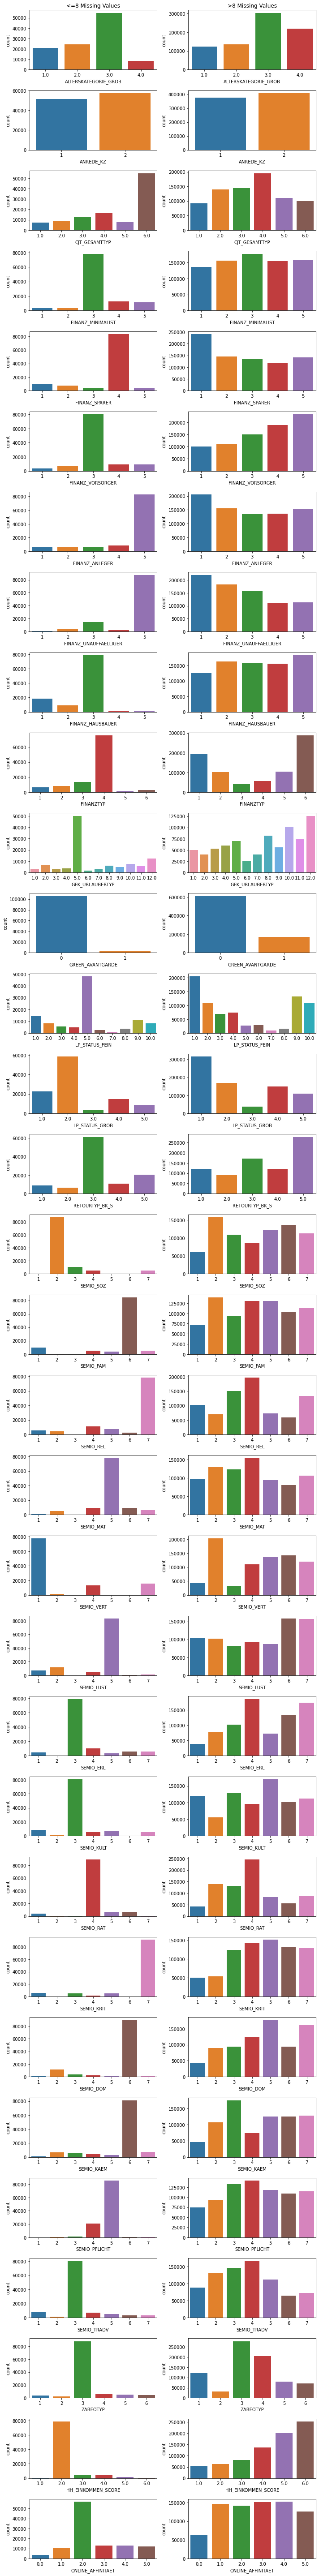

In [75]:
fig, axs = plt.subplots(len(few), 2, figsize=(10,2.5*len(few)))
axs[0,0].set_title("<=8 Missing Values")
axs[0,1].set_title(">8 Missing Values")
for i in range(0, len(few)):
    sns.countplot(x=emp_above[few[i]], ax=axs[i,0])
    sns.countplot(x=emp_below[few[i]], ax=axs[i,1])
plt.tight_layout()
fig.show()
print("Empirical Rule Cutoff:")

In [76]:
final_trim

ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  FINANZ_MINIMALIST  \
0                        2.0          1            2.0                  3   
1                        1.0          2            5.0                  1   
2                        3.0          2            3.0                  1   
3                        4.0          2            2.0                  4   
4                        3.0          1            5.0                  4   
...                      ...        ...            ...                ...   
891216                   3.0          2            5.0                  1   
891217                   2.0          1            4.0                  3   
891218                   2.0          2            4.0                  2   
891219                   1.0          1            3.0                  1   
891220                   4.0          1            1.0                  4   

        FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                   4                 3               5   
1                   5                 2               5   
2                   4                 1               2   
3                   2                 5               2   
4                   3                 4               1   
...               ...               ...             ...   
891216              4                 2               5   
891217              3                 3               2   
891218              4                 2               5   
891219              5                 3               5   
891220              2                 5               2   

        FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  FINANZTYP  ...  PLZ8_ANTG1  \
0                           5                 3          4  ...         NaN   
1                           4                 5          1  ...         2.0   
2                           3                 5          1  ...         3.0   
3                           1                 2          6  ...         2.0   
4                           3                 2          5  ...         2.0   
...                       ...               ...        ...  ...         ...   
891216                      4                 4          1  ...         3.0   
891217                      2                 3          6  ...         1.0   
891218                      4                 3          1  ...         4.0   
891219                      5                 5          1  ...         1.0   
891220                      1                 5          6  ...         3.0   

        PLZ8_ANTG2  PLZ8_ANTG3  PLZ8_ANTG4  PLZ8_BAUMAX  PLZ8_HHZ  PLZ8_GBZ  \
0              NaN         NaN         NaN          NaN       NaN       NaN   
1              3.0         2.0         1.0          1.0       5.0       4.0   
2              3.0         1.0         0.0          1.0       4.0       4.0   
3              2.0         2.0         0.0          1.0       3.0       4.0   
4              4.0         2.0         1.0          2.0       3.0       3.0   
...            ...         ...         ...          ...       ...       ...   
891216         2.0         0.0         0.0          1.0       2.0       3.0   
891217         3.0         3.0         2.0          4.0       5.0       3.0   
891218         2.0         0.0         0.0          1.0       3.0       4.0   
891219         4.0         3.0         1.0          5.0       1.0       1.0   
891220         3.0         1.0         0.0          1.0       4.0       4.0   

        ARBEIT  ORTSGR_KLS9  RELAT_AB  
0          NaN          NaN       NaN  
1          3.0          5.0       4.0  
2          3.0          5.0       2.0  
3          2.0          3.0       3.0  
4          4.0          6.0       5.0  
...        ...          ...       ...  
891216     NaN          NaN       NaN  
891217     4.0          6.0       5.0  
891218     2.0          2.0       3.0  
891219     4.0          7.0       5.0  
891220     3.0          4.0       5.

C:\Users\mujta\AppData\Local\Temp/ipykernel_17812/3561741744.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


20 Missing Value Cutoff:


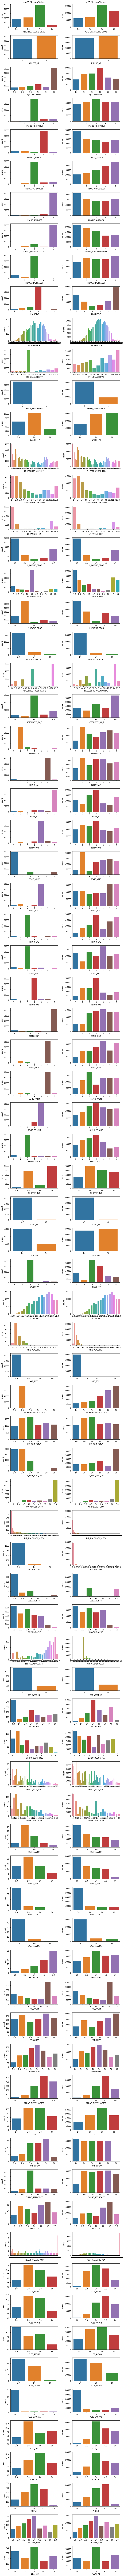

In [77]:
fig, axs = plt.subplots(len(final_trim.columns), 2, figsize=(10,2.5*len(final_trim.columns)))
axs[0,0].set_title("<=20 Missing Values")
axs[0,1].set_title(">20 Missing Values")
for i in range(0, len(final_trim.columns)):
    sns.countplot(x=above_threshold[final_trim.columns[i]], ax=axs[i,0])
    sns.countplot(x=below_threshold[final_trim.columns[i]], ax=axs[i,1])
plt.tight_layout()
fig.show()
print("20 Missing Value Cutoff:")

In [78]:
?sns.countplot

C:\Users\mujta\AppData\Local\Temp/ipykernel_17812/625800113.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Empirical Rule Cutoff:


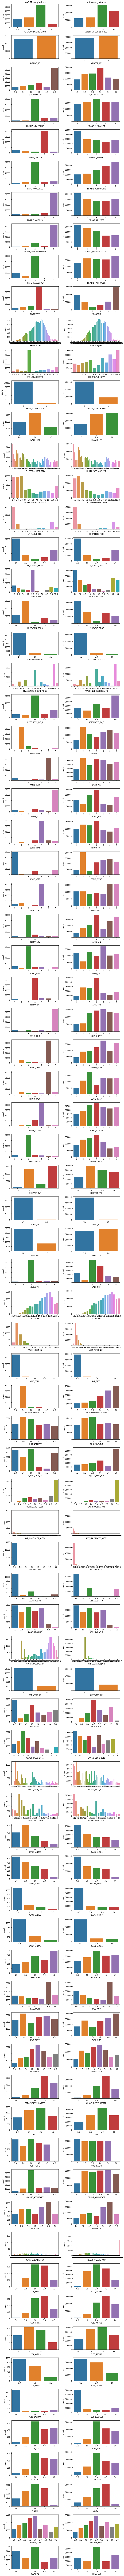

In [79]:
fig, axs = plt.subplots(len(final_trim.columns), 2, figsize=(10,2.5*len(final_trim.columns)))
axs[0,0].set_title("<=8 Missing Values")
axs[0,1].set_title(">8 Missing Values")
for i in range(0, len(final_trim.columns)):
    sns.countplot(x=emp_above[final_trim.columns[i]], ax=axs[i,0])
    sns.countplot(x=emp_below[final_trim.columns[i]], ax=axs[i,1])
plt.tight_layout()
fig.show()
print("Empirical Rule Cutoff:")

#### Discussion 1.1.3: Assess Missing Data in Each Row

With the exception of around one or two columns, it seems that most rows with more missing values than the cutoff have a hugely disproportionate number of one specific value (like 3 in FINANZ_VORSORGER, 7 in SEMIO_KRIT, or 1 in VERS_TYP).

I have also decided to use the subset of few/no missing values based on the 20-nan cutoff in order to retain as much data as is reasonably possible. I will no longer use the empirical rule.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [80]:
# How many features are there of each data type?
feat_info.type.value_counts()


ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64

In [81]:
feat_info[np.logical_or(np.logical_or(feat_info.type=='numeric', feat_info.type=='interval'),feat_info.type=='ordinal')]

attribute information_level     type missing_or_unknown  \
1   ALTERSKATEGORIE_GROB            person  ordinal           [-1,0,9]   
4      FINANZ_MINIMALIST            person  ordinal               [-1]   
5          FINANZ_SPARER            person  ordinal               [-1]   
6       FINANZ_VORSORGER            person  ordinal               [-1]   
7         FINANZ_ANLEGER            person  ordinal               [-1]   
..                   ...               ...      ...                ...   
80              PLZ8_HHZ    macrocell_plz8  ordinal               [-1]   
81              PLZ8_GBZ    macrocell_plz8  ordinal               [-1]   
82                ARBEIT         community  ordinal             [-1,9]   
83           ORTSGR_KLS9         community  ordinal             [-1,0]   
84              RELAT_AB         community  ordinal             [-1,9]   

   missing_lists  
1     [-1, 0, 9]  
4           [-1]  
5           [-1]  
6           [-1]  
7           [-1]  
..           ...  
80          [-1]  
81          [-1]  
82       [-1, 9]  
83       [-1, 0]  
84       [-1, 9]  

[57 rows x 5 columns]

In [82]:
# storing attributes that may need re-encoding into a new variable
to_cast = feat_info[np.logical_or(feat_info.type=='categorical', feat_info.type=='mixed')][np.logical_not(feat_info.attribute.isin(final_drops))]
to_cast

C:\Users\mujta\AppData\Local\Temp/ipykernel_17812/2689377295.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  to_cast = feat_info[np.logical_or(feat_info.type=='categorical', feat_info.type=='mixed')][np.logical_not(feat_info.attribute.isin(final_drops))]


attribute information_level         type missing_or_unknown  \
2          ANREDE_KZ            person  categorical             [-1,0]   
3      CJT_GESAMTTYP            person  categorical                [0]   
10         FINANZTYP            person  categorical               [-1]   
12   GFK_URLAUBERTYP            person  categorical                 []   
13  GREEN_AVANTGARDE            person  categorical                 []   
..               ...               ...          ...                ...   
56          WOHNLAGE          building        mixed               [-1]   
57   CAMEO_DEUG_2015     microcell_rr4  categorical             [-1,X]   
58    CAMEO_DEU_2015     microcell_rr4  categorical               [XX]   
59   CAMEO_INTL_2015     microcell_rr4        mixed            [-1,XX]   
79       PLZ8_BAUMAX    macrocell_plz8        mixed             [-1,0]   

   missing_lists  
2        [-1, 0]  
3            [0]  
10          [-1]  
12            []  
13            []  
..           ...  
56          [-1]  
57          [-1]  
58          [XX]  
59      [-1, XX]  
79       [-1, 0]  

[25 rows x 5 columns]

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [83]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
# all attributes that may need re-encoding
cats = list(to_cast.attribute[to_cast[to_cast.type=="categorical"].attribute.isin(final_trim.columns).index])
cats

['ANREDE_KZ',
 'CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'GREEN_AVANTGARDE',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'SOHO_KZ',
 'VERS_TYP',
 'ZABEOTYP',
 'KK_KUNDENTYP',
 'GEBAEUDETYP',
 'OST_WEST_KZ',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [84]:
len(final_trim[cats[0]].value_counts())

2

In [85]:
# subsetting for multi-level categoricals only:
multis = []
for i in cats:
    if len(final_trim[i].value_counts())>2:
        multis.append(i)

multis

['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'KK_KUNDENTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [86]:
# finding the binary attribute with non-numerical values
final_trim[cats].dtypes[final_trim[cats].dtypes=='object'][np.logical_not(final_trim[cats].dtypes[final_trim[cats].dtypes=='object'].index.isin(multis))]

OST_WEST_KZ    object
dtype: object

In [87]:
# taking a quick glance at OST_WEST_KZ
final_trim.OST_WEST_KZ

0         NaN
1           W
2           W
3           W
4           W
         ... 
891216      W
891217      W
891218      W
891219      W
891220      W
Name: OST_WEST_KZ, Length: 891221, dtype: object

In [88]:
final_trim.OST_WEST_KZ.value_counts()

W    629528
O    168545
Name: OST_WEST_KZ, dtype: int64

In [89]:
# re-encoding OST_WEST_KZ with numerical values
ost_map = {'W': 0, 'O' : 1}
final_trim.OST_WEST_KZ.map(ost_map)

0         NaN
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
891216    0.0
891217    0.0
891218    0.0
891219    0.0
891220    0.0
Name: OST_WEST_KZ, Length: 891221, dtype: float64

In [90]:
# one-hot encoding all multi-level categoricals
onehots = multis

In [91]:
print(onehots)
print(len(onehots))

['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'KK_KUNDENTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']
14


In [92]:
# Re-encode categorical variable(s) to be kept in the analysis.
# One-hot encoding all multi-level categoricals
encoded = pd.get_dummies(below_threshold, columns=onehots)
encoded

ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
1                        1.0          2                  1              5   
2                        3.0          2                  1              4   
3                        4.0          2                  4              2   
4                        3.0          1                  4              3   
5                        1.0          2                  3              1   
...                      ...        ...                ...            ...   
891216                   3.0          2                  1              4   
891217                   2.0          1                  3              3   
891218                   2.0          2                  2              4   
891219                   1.0          1                  1              5   
891220                   4.0          1                  4              2   

        FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  \
1                      2               5                      4   
2                      1               2                      3   
3                      5               2                      1   
4                      4               1                      3   
5                      5               2                      2   
...                  ...             ...                    ...   
891216                 2               5                      4   
891217                 3               2                      2   
891218                 2               5                      4   
891219                 3               5                      5   
891220                 5               2                      1   

        FINANZ_HAUSBAUER  GEBURTSJAHR  GREEN_AVANTGARDE  ...  \
1                      5       1996.0                 0  ...   
2                      5       1979.0                 1  ...   
3                      2       1957.0                 0  ...   
4                      2       1963.0                 0  ...   
5                      5       1943.0                 0  ...   
...                  ...          ...               ...  ...   
891216                 4       1976.0                 0  ...   
891217                 3       1970.0                 0  ...   
891218                 3       1976.0                 0  ...   
891219                 5       1994.0                 0  ...   
891220                 5          NaN                 0  ...   

        CAMEO_DEU_2015_7E  CAMEO_DEU_2015_8A  CAMEO_DEU_2015_8B  \
1                       0                  1                  0   
2                       0                  0                  0   
3                       0                  0                  0   
4                       0                  0                  0   
5                       0                  0                  0   
...                   ...                ...                ...   
891216                  0                  0                  0   
891217                  0                  0                  0   
891218                  0                  0                  0   
891219                  0                  0                  0   
891220                  0                  0                  0   

        CAMEO_DEU_2015_8C  CAMEO_DEU_2015_8D  CAMEO_DEU_2015_9A  \
1                       0                  0                  0   
2                       0                  0                  0   
3                       0                  0                  0   
4                       0                  0                  0   
5                       1                  0                  0   
...                   ...                ...                ...   
891216                  0                  0                  0   
891217                  0                  0                  0   
891218                  0                  0                  0   
891219                  0         

In [93]:
# Re-encoding OST_WEST_KZ
encoded.OST_WEST_KZ = below_threshold.OST_WEST_KZ.map(ost_map)
encoded.OST_WEST_KZ

1         0
2         0
3         0
4         0
5         0
         ..
891216    0
891217    0
891218    0
891219    0
891220    0
Name: OST_WEST_KZ, Length: 796704, dtype: int64

#### Discussion 1.2.1: Re-Encode Categorical Features

I kept all remaining features from the column-dropping step for now. All multi-level categorical features were one-hot encoded and OST_WEST_KZ was re-encoded as a numerical column.

I may consider dropping them when tuning the clustering model if that improves its performance on new data. 

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [94]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
pd.set_option('display.max_rows', None)
print(encoded.PRAEGENDE_JUGENDJAHRE.value_counts())
pd.set_option('display.max_rows', 10)

14.0    182816
8.0     141374
10.0     85716
5.0      84639
3.0      53803
15.0     42467
11.0     35698
9.0      33554
6.0      25650
12.0     24434
1.0      20632
4.0      20447
2.0       7479
13.0      5753
7.0       4009
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64


In [95]:
pd.set_option('display.max_rows', 10)
encoded

ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
1                        1.0          2                  1              5   
2                        3.0          2                  1              4   
3                        4.0          2                  4              2   
4                        3.0          1                  4              3   
5                        1.0          2                  3              1   
...                      ...        ...                ...            ...   
891216                   3.0          2                  1              4   
891217                   2.0          1                  3              3   
891218                   2.0          2                  2              4   
891219                   1.0          1                  1              5   
891220                   4.0          1                  4              2   

        FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  \
1                      2               5                      4   
2                      1               2                      3   
3                      5               2                      1   
4                      4               1                      3   
5                      5               2                      2   
...                  ...             ...                    ...   
891216                 2               5                      4   
891217                 3               2                      2   
891218                 2               5                      4   
891219                 3               5                      5   
891220                 5               2                      1   

        FINANZ_HAUSBAUER  GEBURTSJAHR  GREEN_AVANTGARDE  ...  \
1                      5       1996.0                 0  ...   
2                      5       1979.0                 1  ...   
3                      2       1957.0                 0  ...   
4                      2       1963.0                 0  ...   
5                      5       1943.0                 0  ...   
...                  ...          ...               ...  ...   
891216                 4       1976.0                 0  ...   
891217                 3       1970.0                 0  ...   
891218                 3       1976.0                 0  ...   
891219                 5       1994.0                 0  ...   
891220                 5          NaN                 0  ...   

        CAMEO_DEU_2015_7E  CAMEO_DEU_2015_8A  CAMEO_DEU_2015_8B  \
1                       0                  1                  0   
2                       0                  0                  0   
3                       0                  0                  0   
4                       0                  0                  0   
5                       0                  0                  0   
...                   ...                ...                ...   
891216                  0                  0                  0   
891217                  0                  0                  0   
891218                  0                  0                  0   
891219                  0                  0                  0   
891220                  0                  0                  0   

        CAMEO_DEU_2015_8C  CAMEO_DEU_2015_8D  CAMEO_DEU_2015_9A  \
1                       0                  0                  0   
2                       0                  0                  0   
3                       0                  0                  0   
4                       0                  0                  0   
5                       1                  0                  0   
...                   ...                ...                ...   
891216                  0                  0                  0   
891217                  0                  0                  0   
891218                  0                  0                  0   
891219                  0         

In [96]:
encoded.PRAEGENDE_JUGENDJAHRE[encoded.PRAEGENDE_JUGENDJAHRE.isna()]

40       NaN
72       NaN
156      NaN
158      NaN
159      NaN
          ..
891129   NaN
891139   NaN
891150   NaN
891184   NaN
891203   NaN
Name: PRAEGENDE_JUGENDJAHRE, Length: 28233, dtype: float64

In [97]:
# attepmting to create new lists that will become the engineered columns:
decades = encoded.PRAEGENDE_JUGENDJAHRE.astype('float16')
movement = encoded.PRAEGENDE_JUGENDJAHRE.astype('float16')
movement_dict = {'1': "Mainstream", '2': "Avantgarde", '3': "Mainstream", '4': "Avantgarde",
                 '5': "Mainstream", '6': "Avantgarde", '7': "Avantgarde", '8': "Mainstream",
                 '9': "Avantgarde", '10': "Mainstream", '11': "Avantgarde", '12': "Mainstream",
                 '13': "Avantgarde", '14': "Mainstream", '15': "Avantgarde"}
decade_dict = {'1': '40s', '2': '40s', '3': '50s',
           '4': '50s', '5': '60s', '6': '60s',
           '7': '60s', '8': '70s', '9': '70s',
           '10': '80s', '11': '80s', '12': '80s',
           '13': '80s', '14': '90s', '15': '90s'}
for i in list(decade_dict.keys()):
    decades.replace(float(i), decade_dict[i], inplace=True)
    movement.replace(float(i), movement_dict[i], inplace=True)

In [98]:
decades

1         90s
2         90s
3         70s
4         70s
5         50s
         ... 
891216    90s
891217    80s
891218    90s
891219    90s
891220    50s
Name: PRAEGENDE_JUGENDJAHRE, Length: 796704, dtype: object

In [99]:
movement

1         Mainstream
2         Avantgarde
3         Mainstream
4         Mainstream
5         Mainstream
             ...    
891216    Mainstream
891217    Mainstream
891218    Mainstream
891219    Mainstream
891220    Mainstream
Name: PRAEGENDE_JUGENDJAHRE, Length: 796704, dtype: object

In [100]:
encoded['PRAEGENDE_DC'] = decades
encoded['PRAEGENDE_MV'] = movement
encoded.drop(columns='PRAEGENDE_JUGENDJAHRE', inplace=True)
encoded.columns

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST',
       'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GEBURTSJAHR',
       'GREEN_AVANTGARDE',
       ...
       'CAMEO_DEU_2015_8B', 'CAMEO_DEU_2015_8C', 'CAMEO_DEU_2015_8D',
       'CAMEO_DEU_2015_9A', 'CAMEO_DEU_2015_9B', 'CAMEO_DEU_2015_9C',
       'CAMEO_DEU_2015_9D', 'CAMEO_DEU_2015_9E', 'PRAEGENDE_DC',
       'PRAEGENDE_MV'],
      dtype='object', length=204)

In [101]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
pd.set_option('display.max_rows', None)
print(encoded.CAMEO_INTL_2015.value_counts())
pd.set_option('display.max_rows', 10)

51    133659
41     92286
24     91061
14     62834
43     56636
54     45362
25     39589
22     33123
23     26634
13     26304
45     26119
55     23924
52     20537
31     18954
34     18507
15     16964
44     14815
12     13227
35     10345
32     10345
33      9924
Name: CAMEO_INTL_2015, dtype: int64


In [102]:
encoded.CAMEO_INTL_2015.values

array(['51', '24', '12', ..., '24', '51', '43'], dtype=object)

In [103]:
# attepmting to create new lists that will become the engineered columns:
cameovalues = encoded.CAMEO_INTL_2015.values
wealth = encoded.CAMEO_INTL_2015
life = encoded.CAMEO_INTL_2015
wealth_dict = {}
life_dict = {}
for i in cameovalues:
    # wealth_dict
    try:
        int(i)
    except:
        ;
    else:
        if int(i) in range(10,16):
            wealth_dict[i] = "Wealthy"
        elif int(i) in range(20, 26):
            wealth_dict[i] = "Prosperous"
        elif int(i) in range(30, 36):
            wealth_dict[i] = "Comfortable"
        elif int(i) in range(40, 46):
            wealth_dict[i] = "Less Affluent"
        elif int(i) in range(50, 56):
            wealth_dict[i] = "Poorer"
    
    # life_dict
    try:
        int(i)
    except:
        ;
    else:
        if int(i)%10 == 1:
            life_dict[i] = "Pre-Family Couples & Singles"
        elif int(i)%10 == 2:
            life_dict[i] = "Young Couples With Children"
        elif int(i)%10 == 3:
            life_dict[i] = "Families With School Age Children"
        elif int(i)%10 == 4:
            life_dict[i] = "Older Families & Mature Couples"
        elif int(i)%10 == 5:
            life_dict[i] = "Elders In Retirement"

In [104]:
len(cameovalues)

796704

In [105]:
wealth_dict

{'51': 'Poorer',
 '24': 'Prosperous',
 '12': 'Wealthy',
 '43': 'Less Affluent',
 '54': 'Poorer',
 '22': 'Prosperous',
 '14': 'Wealthy',
 '13': 'Wealthy',
 '15': 'Wealthy',
 '33': 'Comfortable',
 '41': 'Less Affluent',
 '34': 'Comfortable',
 '55': 'Poorer',
 '25': 'Prosperous',
 '23': 'Prosperous',
 '31': 'Comfortable',
 '52': 'Poorer',
 '35': 'Comfortable',
 '45': 'Less Affluent',
 '44': 'Less Affluent',
 '32': 'Comfortable'}

In [106]:
life_dict

{'51': 'Pre-Family Couples & Singles',
 '24': 'Older Families & Mature Couples',
 '12': 'Young Couples With Children',
 '43': 'Families With School Age Children',
 '54': 'Older Families & Mature Couples',
 '22': 'Young Couples With Children',
 '14': 'Older Families & Mature Couples',
 '13': 'Families With School Age Children',
 '15': 'Elders In Retirement',
 '33': 'Families With School Age Children',
 '41': 'Pre-Family Couples & Singles',
 '34': 'Older Families & Mature Couples',
 '55': 'Elders In Retirement',
 '25': 'Elders In Retirement',
 '23': 'Families With School Age Children',
 '31': 'Pre-Family Couples & Singles',
 '52': 'Young Couples With Children',
 '35': 'Elders In Retirement',
 '45': 'Elders In Retirement',
 '44': 'Older Families & Mature Couples',
 '32': 'Young Couples With Children'}

In [107]:
wealthmap = wealth.map(wealth_dict)

In [108]:
lifemap = life.map(life_dict)

In [109]:
lifemap

1              Pre-Family Couples & Singles
2           Older Families & Mature Couples
3               Young Couples With Children
4         Families With School Age Children
5           Older Families & Mature Couples
                        ...                
891216         Pre-Family Couples & Singles
891217         Pre-Family Couples & Singles
891218      Older Families & Mature Couples
891219         Pre-Family Couples & Singles
891220    Families With School Age Children
Name: CAMEO_INTL_2015, Length: 796704, dtype: object

In [110]:
encoded["CAMEO_WEALTH"] = wealthmap
encoded["CAMEO_LIFE"] = lifemap
encoded.drop(columns="CAMEO_INTL_2015", inplace=True)

In [111]:
# Checking on the other Mixed features
feat_info[np.logical_and(feat_info.type=='mixed',
                         np.logical_not(feat_info.attribute.isin(["PRAEGENDE_JUGENDJAHRE", "CAMEO_INTL_2015", "KBA05_BAUMAX"])))]

attribute information_level   type missing_or_unknown  \
15  LP_LEBENSPHASE_FEIN            person  mixed                [0]   
16  LP_LEBENSPHASE_GROB            person  mixed                [0]   
56             WOHNLAGE          building  mixed               [-1]   
79          PLZ8_BAUMAX    macrocell_plz8  mixed             [-1,0]   

   missing_lists  
15           [0]  
16           [0]  
56          [-1]  
79       [-1, 0]

In [112]:
encoded.LP_LEBENSPHASE_FEIN.value_counts()

1.0     58712
5.0     52396
6.0     43318
2.0     37135
8.0     28827
        ...  
22.0     6827
18.0     6798
33.0     5722
17.0     5484
26.0     3368
Name: LP_LEBENSPHASE_FEIN, Length: 40, dtype: int64

In [113]:
encoded.LP_LEBENSPHASE_FEIN.isna().sum()

49405

In [114]:
homeowner_dict = {}
household_dict = {}
income_dict = {}
age_dict = {}

for i in encoded.LP_LEBENSPHASE_FEIN.sort_values():
    try:
        int(i)
    except:
        ;
    else:
        # Homeowner first, since it's binary
        if int(i) in ([10, 11, 12, 18, 19, 27, 
                       34, 37, 38]):
            homeowner_dict[i] = 1
            
            # Household/Marital next
            if int(i) in ([10, 11, 12]):
                household_dict[i] = 0  # Single
            elif int(i) in ([18, 19]):
                household_dict[i] = 1  # Couple
            elif int(i) == 27:
                household_dict[i] = 2  # Family
            elif int(i) in ([34, 37, 38]):
                household_dict[i] = 3  # Multiperson
                
            # Income Bracket third
            if int(i) in ([10, 18]):
                income_dict[i] = 5  # Wealthy Homeowner
            else:
                income_dict[i] = 6  # Homeowner
            
            
        else:
            homeowner_dict[i] = 0
            
            # Household/Marital next
            if int(i) in (range(1,10)):
                household_dict[i] = 0  # Single
            elif int(i) in (range(21, 24)):
                household_dict[i] = 4  # Single Parent
            elif int(i) in ([range(14, 18), 20]):
                household_dict[i] = 1  # Couple
            elif int(i) in ([range(24, 27), 28]):
                household_dict[i] = 2  # Family
            elif int(i) in ([range(29, 34),
                             35, 36, 39, 40]):
                household_dict[i] = 3  # Multiperson
                
            # Income Bracket third
            if int(i) in ([1, 2, 5, 6, 15,
                           21, 24, 29, 31]):
                income_dict[i] = 0  # Low
            elif int(i) in ([3, 4, 7, 8, 16,
                             22, 25, 30, 32]):
                income_dict[i] = 1  # Average
            elif int(i) in ([13, 20, 23, 28,
                             35, 39, 40]):
                income_dict[i] = 2  # Top/High
            elif int(i) in ([9, 17, 26, 33,
                             36]):
                income_dict[i] = 3  # Independent
            elif int(i) == 14:
                income_dict[i] = 4  # Low+Avg Couple
        
        # Finally, the Age bracket
        if int(i) in ([1, 3, 14, 18, 29,
                       30, 33, 34, 35]):
            age_dict[i] = 0  # Younger
        elif int(i) in ([2, 4, 39]):
            age_dict[i] = 1  # Middle
        elif int(i) in ([5, 7, 11, 13, 15, 16,
                         19, 20, 31, 32, 36, 37]):
            age_dict[i] = 2  # Higher/Advanced
        elif int(i) in ([6, 8, 12, 38, 40]):
            age_dict[i] = 3  # Retirement
        else:
            age_dict[i] = -1
            

In [115]:
encoded["LEBENSPHASE_HOMEOWNER"] = encoded.LP_LEBENSPHASE_FEIN.map(homeowner_dict)
encoded["LEBENSPHASE_HOUSEHOLD"] = encoded.LP_LEBENSPHASE_FEIN.map(household_dict)
encoded["LEBENSPHASE_INCOME"] = encoded.LP_LEBENSPHASE_FEIN.map(income_dict)
encoded["LEBENSPHASE_AGE"] = encoded.LP_LEBENSPHASE_FEIN.map(age_dict)
encoded.drop(columns="LP_LEBENSPHASE_FEIN", inplace=True)

In [116]:
encoded.WOHNLAGE.value_counts()

3.0    249487
7.0    169176
4.0    135827
2.0    100281
5.0     74242
1.0     43866
8.0     17324
0.0      6501
Name: WOHNLAGE, dtype: int64

In [117]:
encoded.PLZ8_BAUMAX.value_counts()

1.0    499521
5.0     97332
2.0     70406
4.0     56683
3.0     50731
Name: PLZ8_BAUMAX, dtype: int64

In [118]:
encoded = pd.get_dummies(encoded, columns = ["PRAEGENDE_MV", "PRAEGENDE_DC", "CAMEO_WEALTH", "CAMEO_LIFE", "LEBENSPHASE_HOMEOWNER", "LEBENSPHASE_HOUSEHOLD", "LEBENSPHASE_INCOME", "LEBENSPHASE_AGE", "WOHNLAGE", "PLZ8_BAUMAX"])


In [119]:
encoded

ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
1                        1.0          2                  1              5   
2                        3.0          2                  1              4   
3                        4.0          2                  4              2   
4                        3.0          1                  4              3   
5                        1.0          2                  3              1   
...                      ...        ...                ...            ...   
891216                   3.0          2                  1              4   
891217                   2.0          1                  3              3   
891218                   2.0          2                  2              4   
891219                   1.0          1                  1              5   
891220                   4.0          1                  4              2   

        FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  \
1                      2               5                      4   
2                      1               2                      3   
3                      5               2                      1   
4                      4               1                      3   
5                      5               2                      2   
...                  ...             ...                    ...   
891216                 2               5                      4   
891217                 3               2                      2   
891218                 2               5                      4   
891219                 3               5                      5   
891220                 5               2                      1   

        FINANZ_HAUSBAUER  GEBURTSJAHR  GREEN_AVANTGARDE  ...  WOHNLAGE_3.0  \
1                      5       1996.0                 0  ...             0   
2                      5       1979.0                 1  ...             0   
3                      2       1957.0                 0  ...             0   
4                      2       1963.0                 0  ...             1   
5                      5       1943.0                 0  ...             0   
...                  ...          ...               ...  ...           ...   
891216                 4       1976.0                 0  ...             1   
891217                 3       1970.0                 0  ...             0   
891218                 3       1976.0                 0  ...             0   
891219                 5       1994.0                 0  ...             0   
891220                 5          NaN                 0  ...             0   

        WOHNLAGE_4.0  WOHNLAGE_5.0  WOHNLAGE_7.0  WOHNLAGE_8.0  \
1                  1             0             0             0   
2                  0             0             0             0   
3                  0             0             1             0   
4                  0             0             0             0   
5                  0             0             1             0   
...              ...           ...           ...           ...   
891216             0             0             0             0   
891217             0             1             0             0   
891218             0             0             1             0   
891219             0             1             0             0   
891220             1             0             0             0   

        PLZ8_BAUMAX_1.0  PLZ8_BAUMAX_2.0  PLZ8_BAUMAX_3.0  PLZ8_BAUMAX_4.0  \
1                     1                0                0                0   
2                     1                0                0                0   
3                     1                0                0                0   
4                     0                1                0                0   
5                     1                0                0                0   
...                 ...              ...              ...              ...   
89

#### Discussion 1.2.2: Engineer Mixed-Type Features

I decided to keep WOHNLAGE and PLZ8_BAUMAX without any further modification because each can be more or less encapsulated in a single dimension.

I also dropped LP_LEBENSPHASE_GROB because LP_LEBENSPHASE_FEIN has better information.

What remained of these three as well as PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015 was one-hot encoded.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [120]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)



In [121]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.



All re-engineering and column removal has already been performed.

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [122]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    icount=0
    for i in feat_info.attribute:
        replacers = list(pd.Series([j for j in feat_info.loc[icount,"missing_lists"]]).astype(
            str(df[i].dtype)))
        df.loc[:,i].replace(to_replace = replacers, value = np.NaN, regex = False, inplace = True)
        icount+=1
    
    # remove selected columns and rows, ...
    df.drop(columns=final_drops, inplace=True)
    row_nas = df.isna().sum(1)
    df = df.loc[row_nas[row_nas<=20].index,:]
    
    # select, re-encode, and engineer column values.
    df.OST_WEST_KZ = df.OST_WEST_KZ.map(ost_map)
    
    # PRAEGENDE_JUGENDJAHRE
    decades_ = df.PRAEGENDE_JUGENDJAHRE.astype('float16')
    movement_ = df.PRAEGENDE_JUGENDJAHRE.astype('float16')
    df['PRAEGENDE_DC'] = decades_.map(decade_dict)
    df['PRAEGENDE_MV'] = movement_.map(movement_dict)
    df.drop(columns='PRAEGENDE_JUGENDJAHRE', inplace=True)
    
    # CAMEO_INTL_2015
    df["CAMEO_WEALTH"] = df.CAMEO_INTL_2015.map(wealth_dict)
    df["CAMEO_LIFE"] = df.CAMEO_INTL_2015.map(life_dict)
    df.drop(columns="CAMEO_INTL_2015", inplace=True)    
    
    # LP_LEBENSPHASE_FEIN
    df["LEBENSPHASE_HOMEOWNER"] = df.LP_LEBENSPHASE_FEIN.map(homeowner_dict)
    df["LEBENSPHASE_HOUSEHOLD"] = df.LP_LEBENSPHASE_FEIN.map(household_dict)
    df["LEBENSPHASE_INCOME"] = df.LP_LEBENSPHASE_FEIN.map(income_dict)
    df["LEBENSPHASE_AGE"] = df.LP_LEBENSPHASE_FEIN.map(age_dict)
    df.drop(columns="LP_LEBENSPHASE_FEIN", inplace=True)
    
    # One-hot encoding everything that needs it in one go
    df = pd.get_dummies(df, columns=onehots + ["PRAEGENDE_MV",
        "PRAEGENDE_DC", "CAMEO_WEALTH", "CAMEO_LIFE",
        "LEBENSPHASE_HOMEOWNER", "LEBENSPHASE_HOUSEHOLD",
        "LEBENSPHASE_INCOME", "LEBENSPHASE_AGE", "WOHNLAGE", "PLZ8_BAUMAX"])
    
    # Return the cleaned dataframe.
    return df
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [123]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.


I think it would be best to temporarily remove the missing values. I think replacing all missing values would add a bit too much complication to scaling; I would likely end up having to replace missing values in a way that would not affect the feature scaling, such as replacing them with the mean, or making them blatant outliers so they are omitted as such. It's better to just create a temporary variable to store data with no missing values, perform scaling on that, and then apply the fitted scaler to transform the original.

In [124]:
encoded

ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
1                        1.0          2                  1              5   
2                        3.0          2                  1              4   
3                        4.0          2                  4              2   
4                        3.0          1                  4              3   
5                        1.0          2                  3              1   
...                      ...        ...                ...            ...   
891216                   3.0          2                  1              4   
891217                   2.0          1                  3              3   
891218                   2.0          2                  2              4   
891219                   1.0          1                  1              5   
891220                   4.0          1                  4              2   

        FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  \
1                      2               5                      4   
2                      1               2                      3   
3                      5               2                      1   
4                      4               1                      3   
5                      5               2                      2   
...                  ...             ...                    ...   
891216                 2               5                      4   
891217                 3               2                      2   
891218                 2               5                      4   
891219                 3               5                      5   
891220                 5               2                      1   

        FINANZ_HAUSBAUER  GEBURTSJAHR  GREEN_AVANTGARDE  ...  WOHNLAGE_3.0  \
1                      5       1996.0                 0  ...             0   
2                      5       1979.0                 1  ...             0   
3                      2       1957.0                 0  ...             0   
4                      2       1963.0                 0  ...             1   
5                      5       1943.0                 0  ...             0   
...                  ...          ...               ...  ...           ...   
891216                 4       1976.0                 0  ...             1   
891217                 3       1970.0                 0  ...             0   
891218                 3       1976.0                 0  ...             0   
891219                 5       1994.0                 0  ...             0   
891220                 5          NaN                 0  ...             0   

        WOHNLAGE_4.0  WOHNLAGE_5.0  WOHNLAGE_7.0  WOHNLAGE_8.0  \
1                  1             0             0             0   
2                  0             0             0             0   
3                  0             0             1             0   
4                  0             0             0             0   
5                  0             0             1             0   
...              ...           ...           ...           ...   
891216             0             0             0             0   
891217             0             1             0             0   
891218             0             0             1             0   
891219             0             1             0             0   
891220             1             0             0             0   

        PLZ8_BAUMAX_1.0  PLZ8_BAUMAX_2.0  PLZ8_BAUMAX_3.0  PLZ8_BAUMAX_4.0  \
1                     1                0                0                0   
2                     1                0                0                0   
3                     1                0                0                0   
4                     0                1                0                0   
5                     1                0                0                0   
...                 ...              ...              ...              ...   
89

In [125]:
temp = encoded[np.logical_not(encoded.isna().any(1))]
temp

ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
2                        3.0          2                  1              4   
4                        3.0          1                  4              3   
5                        1.0          2                  3              1   
7                        1.0          1                  3              3   
8                        3.0          1                  4              4   
...                      ...        ...                ...            ...   
891206                   1.0          2                  3              4   
891207                   3.0          2                  5              1   
891211                   3.0          1                  3              2   
891213                   4.0          2                  3              3   
891214                   1.0          2                  1              5   

        FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  \
2                      1               2                      3   
4                      4               1                      3   
5                      5               2                      2   
7                      4               1                      3   
8                      2               4                      2   
...                  ...             ...                    ...   
891206                 2               4                      4   
891207                 5               1                      2   
891211                 4               3                      3   
891213                 3               5                      3   
891214                 2               3                      3   

        FINANZ_HAUSBAUER  GEBURTSJAHR  GREEN_AVANTGARDE  ...  WOHNLAGE_3.0  \
2                      5       1979.0                 1  ...             0   
4                      2       1963.0                 0  ...             1   
5                      5       1943.0                 0  ...             0   
7                      2       1964.0                 0  ...             0   
8                      2       1974.0                 1  ...             0   
...                  ...          ...               ...  ...           ...   
891206                 2       1984.0                 0  ...             0   
891207                 4       1933.0                 1  ...             0   
891211                 2       1963.0                 0  ...             1   
891213                 2       1966.0                 1  ...             0   
891214                 4       1978.0                 0  ...             1   

        WOHNLAGE_4.0  WOHNLAGE_5.0  WOHNLAGE_7.0  WOHNLAGE_8.0  \
2                  0             0             0             0   
4                  0             0             0             0   
5                  0             0             1             0   
7                  0             0             0             0   
8                  0             0             0             0   
...              ...           ...           ...           ...   
891206             0             0             0             0   
891207             1             0             0             0   
891211             0             0             0             0   
891213             1             0             0             0   
891214             0             0             0             0   

        PLZ8_BAUMAX_1.0  PLZ8_BAUMAX_2.0  PLZ8_BAUMAX_3.0  PLZ8_BAUMAX_4.0  \
2                     1                0                0                0   
4                     0                1                0                0   
5                     1                0                0                0   
7                     1                0                0                0   
8                     1                0                0                0   
...                 ...              ...              ...              ...   
89

In [126]:
temp.isna().any().sum()

0

In [127]:
# Apply feature scaling to the general population demographics data.
from sklearn.preprocessing import StandardScaler
SS = StandardScaler()
SS.fit(temp)

StandardScaler()

In [128]:
from sklearn.impute import SimpleImputer
imp_s = SimpleImputer()
imp = imp_s.fit_transform(encoded)
scaled = SS.transform(imp)

### Discussion 2.1: Apply Feature Scaling

As stated above, I stored all rows with no missing values into a temporary variable, fit the scaler to that, and used the result to transform the original dataframe. I also used imputation to replace all missing values with the mean of the column in which they occur.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [129]:
# Apply PCA to the data.
from sklearn.decomposition import PCA
prelim = PCA()
prelim.fit_transform(scaled)


array([[-3.43749963e+00,  4.87099319e+00, -4.91781183e+00, ...,
         4.70683984e-15,  3.51059032e-15, -5.32150291e-16],
       [-3.42867971e+00, -2.76055555e-01, -1.23929792e+00, ...,
         3.37080550e-14, -8.85689172e-16, -8.69570645e-16],
       [-3.35620509e+00, -5.42775543e+00,  1.67027744e+00, ...,
        -2.52031276e-13,  8.60463074e-16, -2.09205527e-15],
       ...,
       [-3.40816490e+00, -1.46723017e+00, -4.12318359e+00, ...,
         2.53891587e-17,  6.77513359e-17,  5.18715137e-18],
       [-3.45030304e+00,  6.79300983e+00, -4.92791549e+00, ...,
         1.50695886e-16, -5.11418242e-17,  4.49652266e-18],
       [-3.45069323e+00,  1.28883785e+00,  3.02239161e+00, ...,
         1.63095431e-16, -1.28717578e-17,  5.40322845e-18]])

In [130]:
# Investigate the variance accounted for by each principal component.
pd.Series(prelim.explained_variance_).sort_values(ascending=False)

0      1.414390e+03
1      1.902946e+01
2      1.306582e+01
3      7.564084e+00
4      6.820309e+00
           ...     
243    5.201164e-30
244    4.770320e-30
245    2.505191e-30
246    2.526359e-31
247    1.111019e-32
Length: 248, dtype: float64

<BarContainer object of 31 artists>

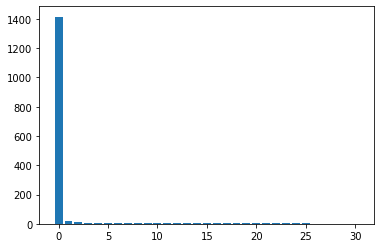

In [131]:
n = 30
plt.bar(range(0, n+1), pd.Series(prelim.explained_variance_).sort_values(ascending=False)[0:(n+1)])

<BarContainer object of 31 artists>

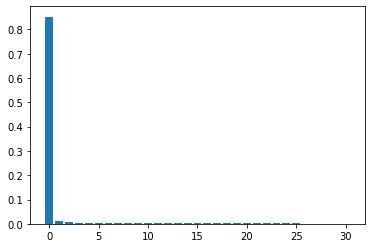

In [132]:
n = 30
plt.bar(range(0, n+1), pd.Series(prelim.explained_variance_ratio_).sort_values(ascending=False)[0:(n+1)])

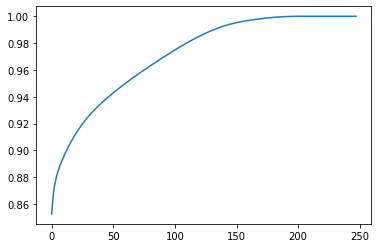

In [133]:
plt.plot(np.cumsum(prelim.explained_variance_ratio_))

In [134]:
?plt.bar

In [135]:
# Re-apply PCA to the data while selecting for number of components to retain.
v99 = PCA(n_components = 125)
v94 = PCA(n_components = 50)
vmin = PCA(n_components = 25)

p99 = v99.fit_transform(scaled)
p94 = v94.fit_transform(scaled)
pmin = vmin.fit_transform(scaled)

### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

While I did store three differently-reduced datasets into three different variables, the one I decided to stick with has 125 components. 125 components is when the returns on variance coverage start to diminish aggressively according to the explained variance ratio plot above. Additionally, it seems to cover about 99% of the variance.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [136]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
v99.components_[1]

array([-6.38140494e-02,  1.34474560e-02, -1.70574742e-01,  9.25746746e-02,
       -6.17347062e-02,  3.89792252e-02,  3.67941473e-02,  1.43366477e-01,
        3.62506517e-02, -8.32872734e-02,  1.82712556e-02, -1.09498313e-01,
       -2.41391097e-03,  2.08376180e-02,  3.98682585e-02,  6.04394783e-02,
        4.05869755e-02, -3.79810335e-02, -3.63860508e-02, -3.52850089e-02,
        3.27044236e-02,  5.08069915e-02,  1.48895149e-02,  2.22944245e-02,
        3.42076156e-02,  6.12166883e-02,  4.24052482e-02, -2.00963570e-03,
        2.18015267e-02,  6.01835621e-03, -7.71136778e-02, -4.06378451e-03,
        1.67150427e-01,  4.64379213e-02, -4.14466277e-02,  1.14484850e-01,
        3.28340217e-02, -1.25348928e-01, -1.01064005e-01,  3.56325897e-02,
       -1.63510176e-01,  1.07623269e-02,  9.97138327e-02,  1.14395956e-01,
       -1.60251752e-01, -8.72482837e-02,  1.41597835e-01, -1.15860951e-01,
       -8.95322319e-02,  3.12073326e-02, -1.78835079e-01, -6.01680264e-02,
        5.14420478e-02, -

In [137]:
wts99 = pd.DataFrame(np.round(v99.components_, 4), columns = encoded.keys())
wts99

ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
0                 -0.0005    -0.0000             0.0009         0.0003   
1                 -0.0638     0.0134            -0.1706         0.0926   
2                  0.2152     0.0209             0.1017        -0.2234   
3                 -0.0023    -0.0803             0.0439        -0.0188   
4                 -0.0019    -0.3386             0.1267        -0.0359   
..                    ...        ...                ...            ...   
120                0.0163     0.0092            -0.0013        -0.0187   
121               -0.0370    -0.0318            -0.0233         0.0006   
122               -0.0024    -0.0091             0.0219        -0.0286   
123               -0.0017     0.0135             0.0389        -0.0142   
124               -0.0234     0.0104            -0.0150        -0.0082   

     FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  \
0             -0.0005          0.0002                 0.0021   
1             -0.0617          0.0390                 0.0368   
2              0.2047         -0.2032                -0.2062   
3              0.0178         -0.0995                 0.0113   
4              0.0214         -0.1105                -0.0407   
..                ...             ...                    ...   
120            0.0361          0.0114                 0.0154   
121            0.0638         -0.0917                -0.0396   
122            0.0188          0.0279                -0.0040   
123            0.0073          0.0483                -0.0064   
124            0.0201         -0.0131                -0.0023   

     FINANZ_HAUSBAUER  GEBURTSJAHR  GREEN_AVANTGARDE  ...  WOHNLAGE_3.0  \
0             -0.0028       0.0005           -0.0000  ...       -0.0016   
1              0.1434       0.0363           -0.0833  ...        0.0308   
2              0.0696      -0.1480           -0.0011  ...        0.0152   
3             -0.0216      -0.0030            0.2472  ...        0.0495   
4             -0.0802      -0.0267           -0.0356  ...       -0.0104   
..                ...          ...               ...  ...           ...   
120           -0.0138      -0.0020            0.0591  ...        0.0304   
121           -0.0363       0.0155           -0.0111  ...       -0.0352   
122            0.0064      -0.0069           -0.0945  ...       -0.0217   
123           -0.0112      -0.0043           -0.0668  ...       -0.0540   
124           -0.0276       0.0035            0.0189  ...       -0.0025   

     WOHNLAGE_4.0  WOHNLAGE_5.0  WOHNLAGE_7.0  WOHNLAGE_8.0  PLZ8_BAUMAX_1.0  \
0         -0.0011       -0.0008       -0.0012       -0.0005          -0.0010   
1          0.0627        0.0505       -0.0932       -0.0614          -0.1550   
2          0.0097        0.0020       -0.0253       -0.0447          -0.0403   
3          0.0024       -0.0040       -0.1187       -0.1038          -0.0461   
4          0.0092        0.0232        0.0094        0.0240          -0.0313   
..            ...           ...           ...           ...              ...   
120       -0.0440       -0.0524        0.0548       -0.0255           0.0019   
121       -0.0075        0.0224       -0.0336        0.0127           0.0359   
122       -0.0890       -0.0683       -0.0302        0.0080          -0.0060   
123       -0.0262       -0.0340       -0.0399        0.0157          -0.0537   
124       -0.1160       -0.0948        0.0339        0.0142          -0.0245   

     PLZ8_BAUMAX_2.0  PLZ8_BAUMAX_3.0  PLZ8_BAUMAX_4.0  PLZ8_BAUMAX_5.0  
0            -0.0006          -0.0005          -0.0005          -0.0008  
1             0.0360           0.0542           0.0710           0.1001  
2             0.0145           0.0175           0.0186           0.0230  
3             0.0227           0.0051           0.0096           0.0470  
4            -0.0010           0.0065           0.0112           0.0265  
..               ...              ...    

In [27]:
list(range(-6,5))

[-6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4]

In [31]:
wts99.iloc[0,:].sort_values(ascending=False)[range(6,-7, -1)].sort_values(ascending=False)

WOHNLAGE_0.0                 0.9997
MIN_GEBAEUDEJAHR             0.0191
CAMEO_DEU_2015_3A            0.0080
FINANZTYP_3                  0.0042
GFK_URLAUBERTYP_2.0          0.0025
CAMEO_DEU_2015_5A            0.0023
CAMEO_DEUG_2015_3            0.0022
WOHNDAUER_2008              -0.0016
WOHNLAGE_3.0                -0.0016
LEBENSPHASE_HOMEOWNER_0.0   -0.0018
SEMIO_LUST                  -0.0019
HH_EINKOMMEN_SCORE          -0.0026
FINANZ_HAUSBAUER            -0.0028
Name: 0, dtype: float64

In [38]:
def plot_pca(comp, i):
    to_plot = comp.iloc[i,:].sort_values(ascending=False)[range(6,-7,-1)].sort_values(ascending=False)
    to_plot.plot(kind='bar')

In [138]:
wts99.iloc[0,:].sort_values(ascending=False)

WOHNLAGE_0.0                 0.9997
MIN_GEBAEUDEJAHR             0.0191
CAMEO_DEU_2015_3A            0.0080
FINANZTYP_3                  0.0042
GFK_URLAUBERTYP_2.0          0.0025
                              ...  
WOHNDAUER_2008              -0.0016
LEBENSPHASE_HOMEOWNER_0.0   -0.0018
SEMIO_LUST                  -0.0019
HH_EINKOMMEN_SCORE          -0.0026
FINANZ_HAUSBAUER            -0.0028
Name: 0, Length: 248, dtype: float64

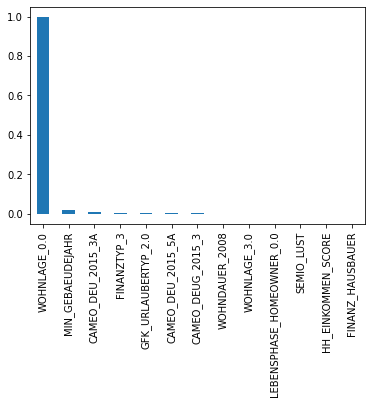

In [39]:
plot_pca(wts99,0)

In [139]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
wts99.iloc[1,:].sort_values(ascending=False)


LP_STATUS_GROB_1.0        0.1782
HH_EINKOMMEN_SCORE        0.1672
PLZ8_ANTG3                0.1620
LEBENSPHASE_INCOME_0.0    0.1608
PLZ8_ANTG4                0.1563
                           ...  
PLZ8_ANTG1               -0.1600
KBA05_GBZ                -0.1603
KBA05_ANTG1              -0.1635
FINANZ_MINIMALIST        -0.1706
MOBI_REGIO               -0.1788
Name: 1, Length: 248, dtype: float64

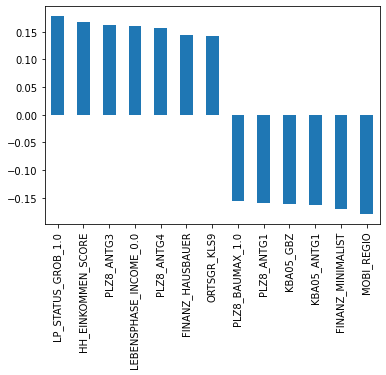

In [40]:
plot_pca(wts99,1)

In [140]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
wts99.iloc[2,:].sort_values(ascending=False)


ALTERSKATEGORIE_GROB     0.2152
FINANZ_VORSORGER         0.2047
ZABEOTYP_3               0.1947
SEMIO_ERL                0.1575
SEMIO_LUST               0.1502
                          ...  
SEMIO_TRADV             -0.1862
SEMIO_REL               -0.1958
FINANZ_ANLEGER          -0.2032
FINANZ_UNAUFFAELLIGER   -0.2062
FINANZ_SPARER           -0.2234
Name: 2, Length: 248, dtype: float64

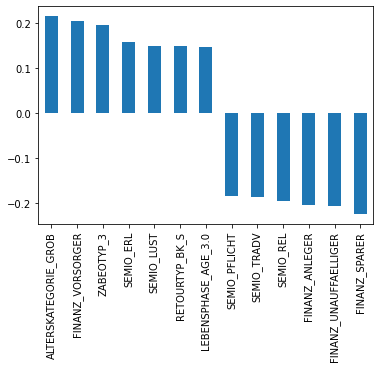

In [41]:
plot_pca(wts99,2)

### Discussion 2.3: Interpret Principal Components

I am honestly surprised that WOHNLAGE_0.0 has such a high weight. It makes me a little suspicious, but I think I'll just have to see how well the model performs instead of jumping to conclusions.

It's also interesting how the top three positive and negative features in the third principal component seem to actually have a higher-magnitude weight towards their component than any of the features plotted for the second. Also, none of the features in the plot for the second component happen to stand out much, which again almost feels too neat to be true.

The third component was a bit better, even if the magnitudes of the weights are still relatively close together, with estimated age, financial planning, and "fair-supplied" energy consumption standing out among the positively-weighted features, while all of the negatively-weighted features (namely active saving, "inconspicuous financial behaviour," investing, religiosity, traditionality, and dutifulness) have almost the same magnitude (around 0.2, or 20%) as those three. 

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [141]:
# Over a number of different cluster counts...
from sklearn.cluster import KMeans
init = KMeans()
init_out = init.fit_transform(p99)

    # run k-means clustering on the data and...
    
    
    # compute the average within-cluster distances.
    
    

In [142]:
mean = 0
count = 0
for i in init_out:
    mean += np.min(i)
    count += 1
mean /= count
mean

13.379696828237668

In [2]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
scores = []
for i in range(1, 31):
    km = KMeans(i)
    km_out = km.fit_transform(p99)
    
    mean = 0
    count = 0
    for j in km_out:
        mean += np.min(j)
        count += 1
    mean /= count
    scores.append(mean)

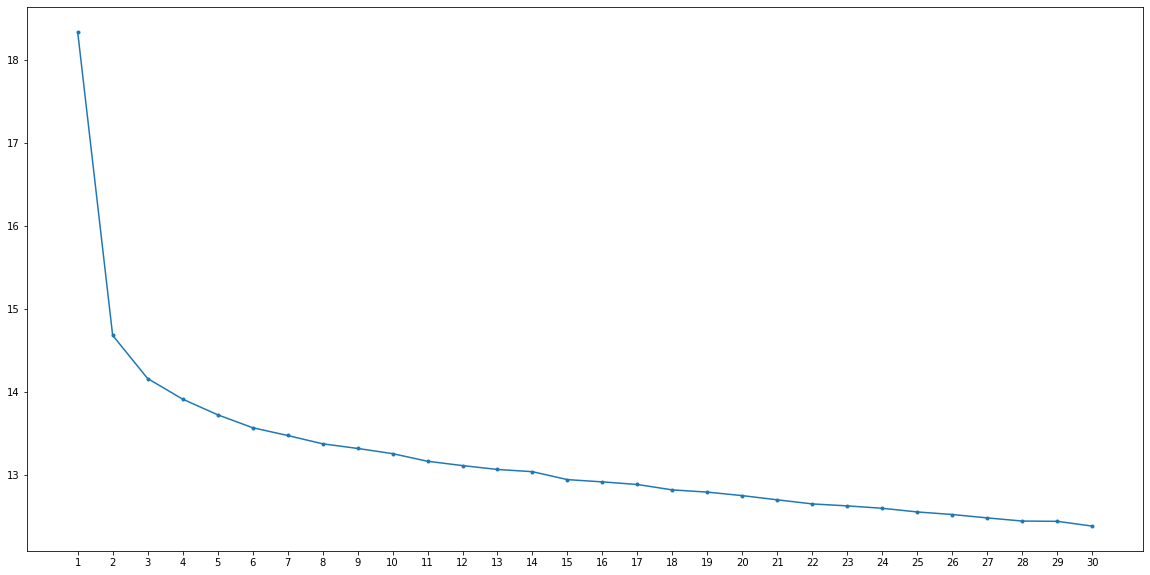

In [16]:
scorefig, scoreax = plt.subplots(1, 1, figsize = (20, 10))
scoreax.plot(range(1, 31), scores, marker = '.')
scoreax.set_xticks(range(1,31))
plt.show()

In [2]:
from sklearn.cluster import MiniBatchKMeans

In [3]:
batchscores = []
for i in range(1, 31):
    mkm = MiniBatchKMeans(i)
    mkm_out = mkm.fit_transform(p99)
    
    mean = 0
    count = 0
    for j in mkm_out:
        mean += np.min(j)
        count += 1
    mean /= count
    batchscores.append(mean)

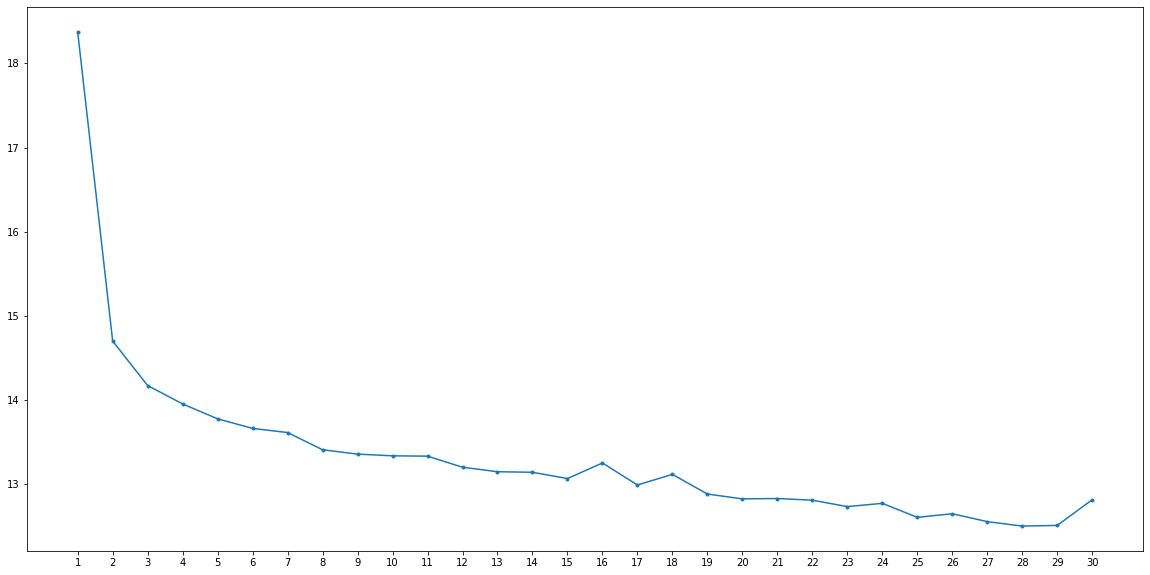

In [4]:
bscorefig, bscoreax = plt.subplots(1, 1, figsize = (20, 10))
bscoreax.plot(range(1, 31), batchscores, marker = '.')
bscoreax.set_xticks(range(1,31))
plt.show()

In [5]:
print(scores[-1])
print(batchscores[-1])

12.38722660129561
12.811669322193607


In [148]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmf = KMeans(30)
kmf.fit(p99)
kmf_out = kmf.predict(p99)


In [149]:
kmf_out

array([16, 15, 29, ..., 11,  6,  8])

### Discussion 3.1: Apply Clustering to General Population

I decided to use 30 clusters to make the clusters as tight as I could without using more clusters than advised.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [150]:
?pd.read_csv

In [151]:
# Load in the customer demographics data.
customers = pd.read_csv("Udacity_CUSTOMERS_Subset.csv", delimiter = ";")
customers

AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0              2                     4          1            5.0   
1             -1                     4          1            NaN   
2             -1                     4          2            2.0   
3              1                     4          1            2.0   
4             -1                     3          1            6.0   
...          ...                   ...        ...            ...   
191647         1                     3          1            4.0   
191648        -1                     4          2            2.0   
191649         2                     4          1            2.0   
191650         3                     3          2            4.0   
191651         3                     2          1            2.0   

        FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                       5              1                 5               1   
1                       5              1                 5               1   
2                       5              1                 5               1   
3                       5              1                 5               2   
4                       3              1                 4               4   
...                   ...            ...               ...             ...   
191647                  5              1                 5               1   
191648                  5              1                 5               2   
191649                  5              1                 5               1   
191650                  2              1                 5               1   
191651                  5              1                 5               1   

        FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  ...  PLZ8_ANTG1  PLZ8_ANTG2  \
0                           2                 2  ...         3.0         3.0   
1                           3                 2  ...         NaN         NaN   
2                           4                 4  ...         2.0         3.0   
3                           1                 2  ...         3.0         2.0   
4                           5                 2  ...         2.0         4.0   
...                       ...               ...  ...         ...         ...   
191647                      1                 2  ...         2.0         4.0   
191648                      2                 3  ...         NaN         NaN   
191649                      1                 2  ...         3.0         2.0   
191650                      2                 5  ...         3.0         2.0   
191651                      1                 2  ...         3.0         2.0   

        PLZ8_ANTG3  PLZ8_ANTG4  PLZ8_BAUMAX  PLZ8_HHZ  PLZ8_GBZ  ARBEIT  \
0              1.0         0.0          1.0       5.0       5.0     1.0   
1              NaN         NaN          NaN       NaN       NaN     NaN   
2              3.0         1.0          3.0       3.0       2.0     3.0   
3              1.0         0.0          1.0       3.0       4.0     1.0   
4              2.0         1.0          2.0       3.0       3.0     3.0   
...            ...         ...          ...       ...       ...     ...   
191647         2.0         1.0          2.0       5.0       4.0     3.0   
191648         NaN         NaN          NaN       NaN       NaN     1.0   
191649         2.0         1.0          1.0       5.0       5.0     3.0   
191650         1.0         1.0          1.0       2.0       3.0     3.0   
191651         0.0         0.0          1.0       4.0       5.0     1.0   

        ORTSGR_KLS9  RELAT_AB  
0               2.0       1.0  
1               NaN       NaN  
2               5.0       3.0  
3               3.0       1.0  
4               5.0       1.0  
...             ...       ...  
191647          8.0       5.0  
191648          4.0       1.0  
191649          7.0       5.0  
191650          4.0       4.0  
191651          3.0       1.0  

[191652

In [152]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
cms = clean_data(customers)


C:\Users\mujta\AppData\Local\Temp/ipykernel_17812/3504644923.py:14: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  replacers = list(pd.Series([j for j in feat_info.loc[icount,"missing_lists"]]).astype(


In [153]:
cms

ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
0                        4.0          1                  5              1   
2                        4.0          2                  5              1   
3                        4.0          1                  5              1   
4                        3.0          1                  3              1   
5                        3.0          1                  5              1   
...                      ...        ...                ...            ...   
191647                   3.0          1                  5              1   
191648                   4.0          2                  5              1   
191649                   4.0          1                  5              1   
191650                   3.0          2                  2              1   
191651                   2.0          1                  5              1   

        FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  \
0                      5               1                      2   
2                      5               1                      4   
3                      5               2                      1   
4                      4               4                      5   
5                      5               1                      2   
...                  ...             ...                    ...   
191647                 5               1                      1   
191648                 5               2                      2   
191649                 5               1                      1   
191650                 5               1                      2   
191651                 5               1                      1   

        FINANZ_HAUSBAUER  GEBURTSJAHR  GREEN_AVANTGARDE  ...  WOHNLAGE_3.0  \
0                      2          NaN                 1  ...             0   
2                      4          NaN                 1  ...             0   
3                      2          NaN                 0  ...             0   
4                      2       1960.0                 0  ...             1   
5                      3          NaN                 1  ...             0   
...                  ...          ...               ...  ...           ...   
191647                 2          NaN                 1  ...             0   
191648                 3          NaN                 0  ...             1   
191649                 2       1944.0                 1  ...             1   
191650                 5          NaN                 0  ...             0   
191651                 2       1937.0                 0  ...             0   

        WOHNLAGE_4.0  WOHNLAGE_5.0  WOHNLAGE_7.0  WOHNLAGE_8.0  \
0                  0             0             1             0   
2                  0             0             0             0   
3                  0             0             1             0   
4                  0             0             0             0   
5                  0             0             0             0   
...              ...           ...           ...           ...   
191647             0             0             0             0   
191648             0             0             0             0   
191649             0             0             0             0   
191650             0             0             0             0   
191651             0             0             1             0   

        PLZ8_BAUMAX_1.0  PLZ8_BAUMAX_2.0  PLZ8_BAUMAX_3.0  PLZ8_BAUMAX_4.0  \
0                     1                0                0                0   
2                     0                0                1                0   
3                     1                0                0                0   
4                     0                1                0                0   
5                     1                0                0                0   
...                 ...              ...              ...              ...   
19

In [154]:
fillers = list(set.difference(set(encoded.columns),set(cms.columns)))
fillers

['PRAEGENDE_MV_Avantgarde',
 'GEBAEUDETYP_5.0',
 'PRAEGENDE_DC_90s',
 'PRAEGENDE_DC_60s',
 'PRAEGENDE_DC_50s',
 'PRAEGENDE_DC_80s',
 'PRAEGENDE_DC_70s',
 'PRAEGENDE_DC_40s',
 'PRAEGENDE_MV_Mainstream']

In [155]:
for i in fillers:
    cms[i] = np.zeros(cms.shape[0])

In [156]:
list(set.difference(set(encoded.columns),set(cms.columns)))

[]

In [157]:
cms.isna().sum().sum()

174561

In [158]:
cms_res = kmf.predict(v99.transform(SS.transform(imp_s.transform(cms))))
cms_res

array([26, 25,  7, ...,  3, 15, 25])

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [159]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
kmf_out

array([16, 15, 29, ..., 11,  6,  8])

In [160]:
cms_res

array([26, 25,  7, ...,  3, 15, 25])

In [161]:
?sns.countplot

In [162]:
len(pd.Series(kmf_out).value_counts(normalize=True))

30

In [163]:
pd.Series(cms_res).value_counts(normalize=True).index.sort_values()

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
           dtype='int64')

In [172]:
cms_plot = pd.Series(cms_res).value_counts(normalize=True)
cms_plot.sort_index()

0     0.002013
1     0.086985
2     0.030255
3     0.138234
4     0.002303
        ...   
25    0.083637
26    0.106842
27    0.056512
28    0.017243
29    0.023728
Length: 30, dtype: float64

In [173]:
len(cms_plot)

30

In [174]:
kmf_plot = pd.Series(kmf_out).value_counts(normalize=True)

(0.0, 0.15)

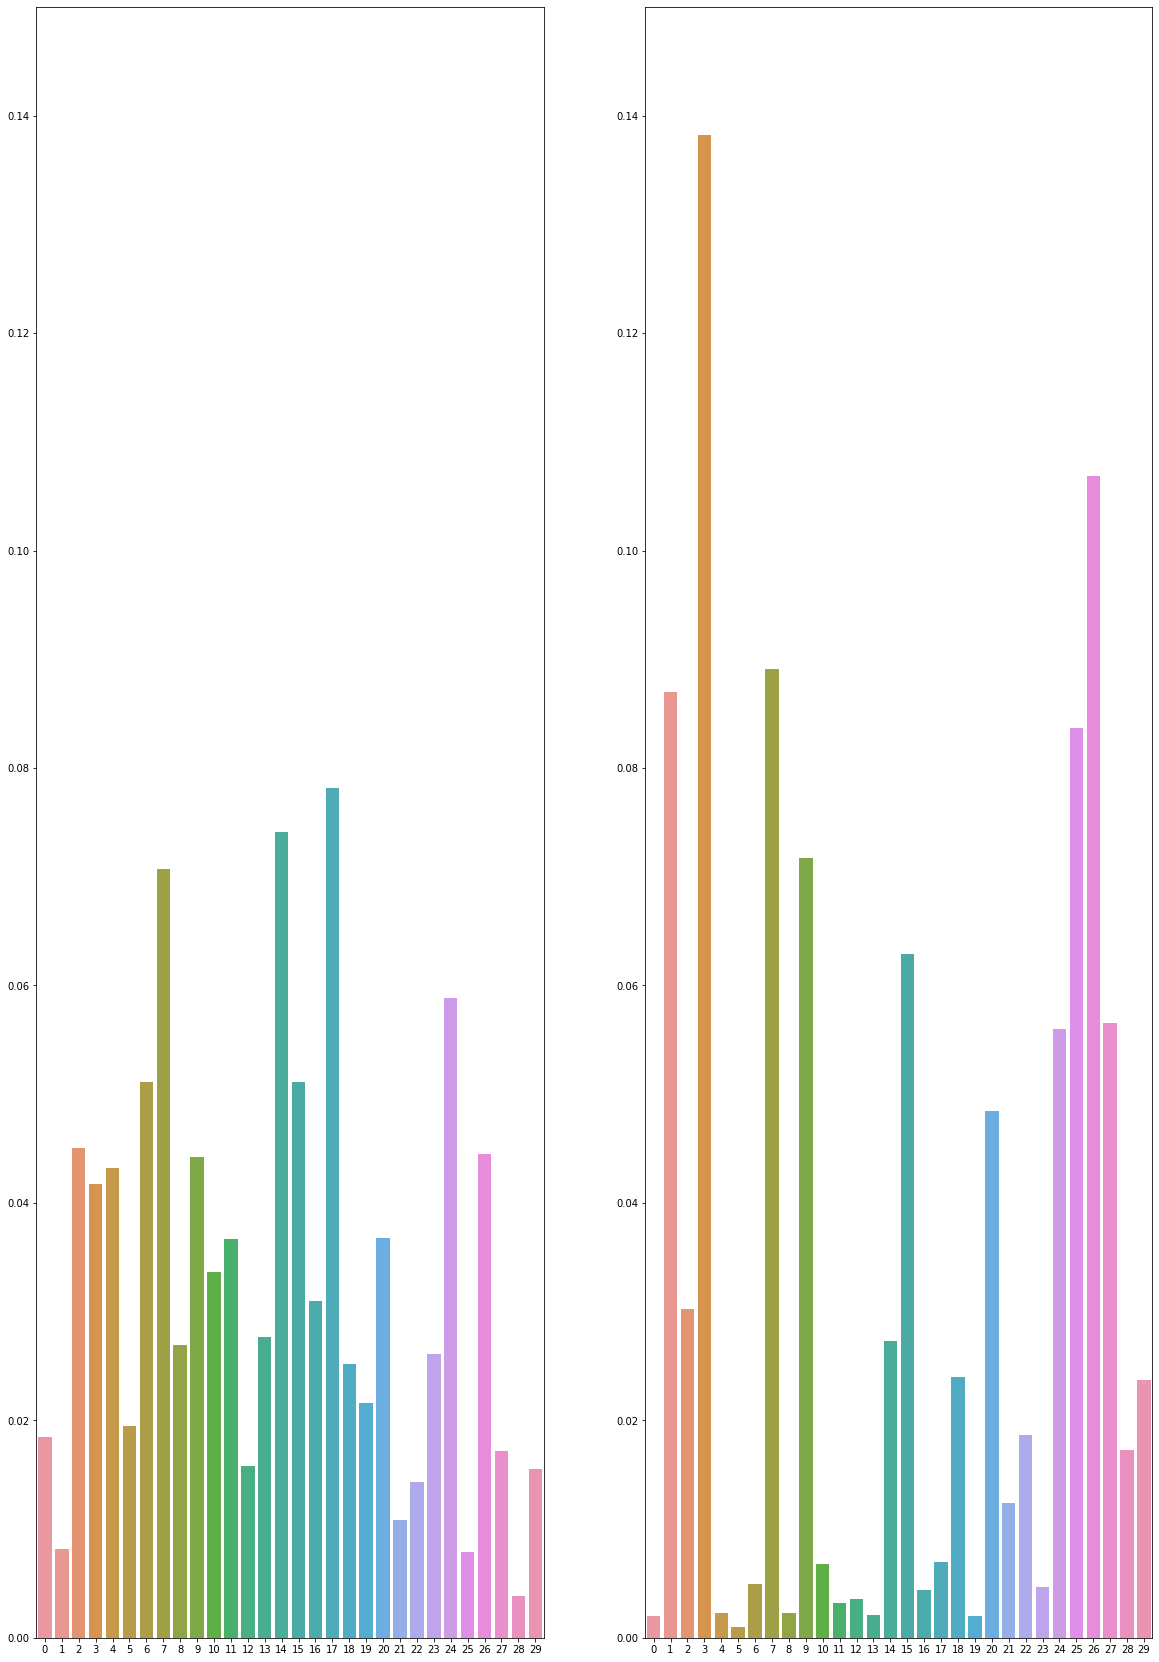

In [177]:
fig, axs = plt.subplots(1, 2, figsize=(20,30))
sns.barplot(x=np.arange(0,30),y=kmf_plot.sort_index(), ax=axs[0])
axs[0].set_ylim([0,0.15])
sns.barplot(x=np.arange(0,30),y=cms_plot.sort_index(), ax=axs[1])
axs[1].set_ylim([0,0.15])

In [179]:
rep_diff = kmf_plot.sort_index() - cms_plot.sort_index()

<AxesSubplot:>

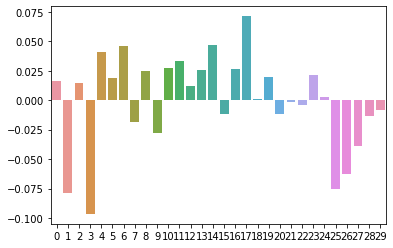

In [180]:
sns.barplot(x=np.arange(0,30),y=rep_diff)

# Positive => more representation in general subset
# Negative => more representation in customer subset

<AxesSubplot:>

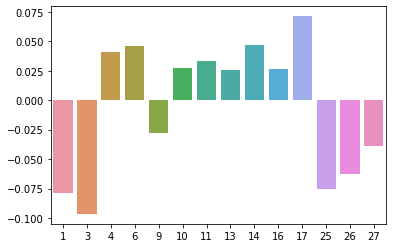

In [181]:
# Cutting out clusters with less than 2.5% representation difference
sns.barplot(x=rep_diff[np.abs(rep_diff)>0.025].index,y=rep_diff[np.abs(rep_diff)>0.025])

<AxesSubplot:>

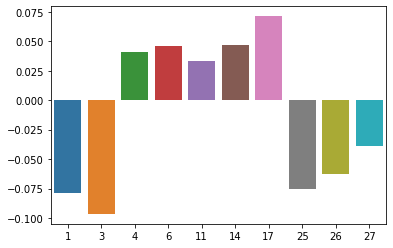

In [182]:
# Cutting out clusters with less than 3% representation difference
# since some remaining clusters have very close to a 2.5% difference
sns.barplot(x=rep_diff[np.abs(rep_diff)>0.03].index,y=rep_diff[np.abs(rep_diff)>0.03])

Centroids 1, 3, 17, and 25 have the largest discrepancies in representation by a noticeable margin, so I will focus on those four in particular.

In [186]:
centroids = SS.inverse_transform(v99.inverse_transform(kmf.cluster_centers_))
centroids

array([[1.88507129e+00, 1.53394803e+00, 1.66096721e+00, ...,
        8.65905946e-02, 1.02687640e-01, 2.00783270e-01],
       [2.60479130e+00, 1.51545460e+00, 3.57115104e+00, ...,
        1.23039214e-02, 1.43025121e-02, 2.00086562e-02],
       [3.48647518e+00, 1.72457109e+00, 3.10762192e+00, ...,
        3.45108217e-02, 1.54617688e-02, 1.00429718e-02],
       ...,
       [3.20586575e+00, 1.49720691e+00, 4.29757677e+00, ...,
        9.47614682e-03, 9.02801700e-03, 4.69846254e-03],
       [3.03160110e+00, 1.43434579e+00, 3.55868887e+00, ...,
        3.20685363e-02, 8.96809912e-02, 1.20515522e-01],
       [2.78765265e+00, 1.51571790e+00, 3.88492438e+00, ...,
        2.18368254e-03, 7.17569297e-03, 7.00083152e-03]])

In [187]:
centroids = pd.DataFrame(data = centroids, columns=encoded.columns).loc[[1,3,17,25],:]
centroids

ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
1               2.604791   1.515455           3.571151       2.889858   
3               3.080265   1.492108           4.525682       2.044550   
17              1.811889   1.986662           1.011748       4.570378   
25              3.496037   1.712158           2.649825       1.561452   

    FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  \
1           3.124329        2.929251               3.841267          1.531012   
3           3.694955        2.114988               2.476482          1.832206   
17          2.147112        4.526975               4.024409          4.397703   
25          4.371837        1.739724               1.755140          4.527665   

    GEBURTSJAHR  GREEN_AVANTGARDE  ...  WOHNLAGE_3.0  WOHNLAGE_4.0  \
1   1970.573166          0.218267  ... -8.496745e-07     -0.000006   
3   1962.959651          0.986078  ...  3.642583e-01      0.086085   
17  1977.382789          0.036665  ...  3.985374e-01      0.249199   
25  1960.677609          0.066460  ...  3.703439e-01      0.215527   

    WOHNLAGE_5.0  WOHNLAGE_7.0  WOHNLAGE_8.0  PLZ8_BAUMAX_1.0  \
1      -0.000008  6.533475e-08  4.503089e-08         0.429928   
3       0.025943  1.957167e-01  9.260332e-04         0.879401   
17      0.113542  4.344134e-02  6.129240e-05         0.432488   
25      0.094359  7.364680e-02  8.915252e-03         0.393443   

    PLZ8_BAUMAX_2.0  PLZ8_BAUMAX_3.0  PLZ8_BAUMAX_4.0  PLZ8_BAUMAX_5.0  
1          0.016758         0.012304         0.014303         0.020009  
3          0.067697         0.007023         0.003442         0.031024  
17         0.141475         0.105685         0.104280         0.200030  
25         0.109519         0.067052         0.144586         0.206570  

[4 rows x 248 columns]

In [188]:
centroids.loc[[1,3,25],:]

ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
1               2.604791   1.515455           3.571151       2.889858   
3               3.080265   1.492108           4.525682       2.044550   
25              3.496037   1.712158           2.649825       1.561452   

    FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  \
1           3.124329        2.929251               3.841267          1.531012   
3           3.694955        2.114988               2.476482          1.832206   
25          4.371837        1.739724               1.755140          4.527665   

    GEBURTSJAHR  GREEN_AVANTGARDE  ...  WOHNLAGE_3.0  WOHNLAGE_4.0  \
1   1970.573166          0.218267  ... -8.496745e-07     -0.000006   
3   1962.959651          0.986078  ...  3.642583e-01      0.086085   
25  1960.677609          0.066460  ...  3.703439e-01      0.215527   

    WOHNLAGE_5.0  WOHNLAGE_7.0  WOHNLAGE_8.0  PLZ8_BAUMAX_1.0  \
1      -0.000008  6.533475e-08  4.503089e-08         0.429928   
3       0.025943  1.957167e-01  9.260332e-04         0.879401   
25      0.094359  7.364680e-02  8.915252e-03         0.393443   

    PLZ8_BAUMAX_2.0  PLZ8_BAUMAX_3.0  PLZ8_BAUMAX_4.0  PLZ8_BAUMAX_5.0  
1          0.016758         0.012304         0.014303         0.020009  
3          0.067697         0.007023         0.003442         0.031024  
25         0.109519         0.067052         0.144586         0.206570  

[3 rows x 248 columns]

In [189]:
centroids.loc[17,:]

ALTERSKATEGORIE_GROB    1.811889
ANREDE_KZ               1.986662
FINANZ_MINIMALIST       1.011748
FINANZ_SPARER           4.570378
FINANZ_VORSORGER        2.147112
                          ...   
PLZ8_BAUMAX_1.0         0.432488
PLZ8_BAUMAX_2.0         0.141475
PLZ8_BAUMAX_3.0         0.105685
PLZ8_BAUMAX_4.0         0.104280
PLZ8_BAUMAX_5.0         0.200030
Name: 17, Length: 248, dtype: float64

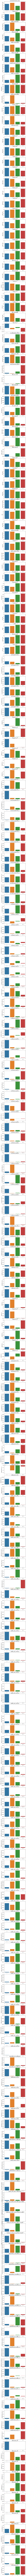

In [191]:
fig, axs = plt.subplots(248, 1, figsize=(6,3*248))
for i in range(0,248):
    sns.barplot(x=[1,3,17,25],y=centroids.iloc[:,i], ax=axs[i])
    axs[i].set_title(centroids.columns[i])

Significant Discrepancies Between Centroid 6 and the Rest (Unordered):
- FINANZ_MINIMALIST
- FINANZ_SPARER
- FINANZ_ANLEGER
- SEMIO_LUST
- ANZ_TITEL (?)
- KBA05_ANTG3
- CJT_GESAMTTYP_1.0
- CJT_GESAMTTYP_5.0
- FINANZTYP_1 ,5
- FINANZTYP_2 ,3 (May be missing)
- GFK_URLAUBERTYP_7.0
- LP_FAMILIE_FEIN_3.0 ,5.0
- LP_STATUS_FEIN_4.0 ,7.0
- NATIONALITAET_KZ (ALL)
- SHOPPER_TYP_2.0 ,3.0
- ZABEOTYP_1 ,3 ,4 ,5
- GEBAUDETYP_2.0 ,6.0 ,8.0
- CAMEO_DEUG_2015_7 ,8
- CAMEO_DEU_2015_5D ,6A ,6E ,7A ,7B ,7C ,8A ,8B ,8C ,8D ,9A ,9B ,9C ,9D
- PRAEGENDE_DC_40s ,50s ,60s ,70s ,90s 
- CAMEO_WEALTH_Less_Affluent
- CAMEO_LIFE_Pre-Family Couples & Singles
- LEBENSPHASE_INCOME_4.0 ,6.0
- LEBENSPHASE_AGE_0.0 ,2.0 ,3.0
- WOHNLAGE_4.0 ,5.0 ,7.0 ,8.0
- PLZ8_BAUMAX_3.0

Significant Discrepancies with Centroid 17:

- FINANZ_MINIMALIST
- FINANZ_SPARER
- FINANZ_VORSORGER (?)
- FINANZ_ANLEGER
- FINANZ_UNAUFFAELLIGERR (?)
- FINANZ_HAUSBAUER (?)
- SEMIO_REL (?)
- SEMIO_VERT (?)
- SEMIO_RAT (?)
- SEMIO_DOM (?)
- SEMIO_KAEM (?)
- SEMIO_PFLICTH
- SEMIO_TRADV (?)
- HH_EINKOMMEN_SCORE (?)
- KBA05_ANTG3
- FINANZTYP_1
- FINANZTYP_2 (?)
- LP_FAMILIE_FEIN_1.0
- LP_FAMILIE_GROB_1.0
- LP_STATUS_FEIN_2.0
- LP_STATUS_FEIN_4.0
- LP_STATUS_GROB_1.0
- NATIONALITAET_KZ_1.0
- SHOPPER_TYP_2.0
- SHOPPER_TYP_3.0
- ZABEOTYP_4
- CAMEO_DEUG_2015_8
- PRAEGENDE_DC_90s
- CAMEO_WEALTH_Less Affluent
- CAMEO_WEALTH_Poorer
- CAMEO_LIFE_Pre-Family Couples & Singles
- LEBENSPHASE_HOUSEHOLD_0.0 (?)
- LEBENSPHASE_INCOME_0.0
- LEBENSPHASE_AGE_0.0

In [ ]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?



In [ ]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?



### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

I focused on Centroids 1, 3, 17, and 25. 17 is overrepresented in the customer subset, while the other three are overrepresented in the general population compared to the subset. Below are major feature differences that this set of centroids brought to light:

- FINANZ_MINIMALIST: Cluster 17 shows high tendencies towards financial minimalism while the other three tend to display average or lower tendencies.
- FINANZ_SPARER: Cluster 17 shows low or very low tendencies towards active saving while the other three tend to display average or higher tendencies.
- FINANZ_VORSORGER: Cluster 17 shows somewhat higher tendencies towards active financial planning than the other three clusters, which suggest average or lower tendencies to that end.
- FINANZ_ANLEGER: Cluster 17 shows very low tendencies toward investing, while the others show average or high tendencies to that end.
- FINANZ_HAUSBAUER: Cluster 17 shows low tendencies towards home ownership. Cluster 25 shows even lower tendencies to this end, but other features suggest this has to do with cluster 25 containing mostly elderly folk in retirement. Based on those same features, it is likely that cluster 17 contains mostly younger people and couples, if not a somewhat more diverse variety.
- SEMIO_REL: Cluster 17 seems to have lower affinity for religion while the other three have average or higher affinity.
- SEMIO_VERT: Cluster 17 shows a very high affinity to dreamfulness while the other three display a low or very low affinity.
- SEMIO_RAT: Cluster 17 shows a very low affinity to rationality while the other three display an average or high affinity.
- SEMIO_PFLICTH: Cluster 17 shows a very low affinity to being dutiful while the other three display an average or high affinity.
- SEMIO_TRADV: Cluster 17 shows a low affinity to traditionality while the other three display an average or higher affinity.
- HH_EINKOMMEN_SCORE: Cluster 17 shows a tendency towards being in a lower income bracket. Cluster 25 shows an even greater tendency to that end, but other features suggest this has to do with cluster 25 containing mostly elderly folk in retirement. Based on those same features, it is likely that cluster 17 contains mostly younger people and couples, if not a somewhat more diverse variety.
- KBA05_ANTG3: Those in Cluster 17 tend to have a lower share of 6-10 family homes in their microcell. Cluster 1 is somewhat associated with this too, but nowhere near as much. The other two clusters show no significant association to this.
- FINANZTYP_1: Cluster 17 shows a very strong association to minimalism, while none of the other three show any significant correlation.
- LP_FAMILIE_FEIN_1.0: Cluster 17 is somewhat associated with the label "Single." Cluster 25 has an even stronger association to it, but other features suggest this has to do with cluster 25 containing mostly elderly folk in retirement. Based on those same features, it is likely that cluster 17 contains mostly younger people and couples, if not a somewhat more diverse variety.
- LP_FAMILIE_GROB_1.0 Cluster 17 is somewhat associated with the label "Single." Cluster 25 has an even stronger association to it, but other features suggest this has to do with cluster 25 containing mostly elderly folk in retirement. Based on those same features, it is likely that cluster 17 contains mostly younger people and couples, if not a somewhat more diverse variety.
- LP_STATUS_FEIN_2.0: Cluster 17 shows an association to the label "orientation-seeking low income earner." None of the other three show any significant association to this.
- LP_STATUS_GROB_1.0: Cluster 17 shows an extremely strong association to low-income earnings. Cluster 25 is a close second, but other features suggest this has to do with cluster 25 containing mostly elderly folk in retirement. Based on those same features, it is likely that cluster 17 contains mostly younger people and couples, if not a somewhat more diverse variety.
- NATIONALITAET_KZ_1.0: While all clusters correlate to having members with German-sounding given names, cluster 17 has the weakest association to this by far. It is not weak in an absolute sense, but is noticeably weaker than the others.
- SHOPPER_TYP_2.0: While cluster 17 does not have a strong correlation to the label "family shopper" in an absolute sense, its association is significantly stronger than that of any other cluster.
- SHOPPER_TYP_3.0: While the other three clusters' correlations to the label "demanding shopper" range from weak to very weak, cluster 17's correlation to it is extremely weak.
- ZABEOTYP_4: While the correlation is still weak in an absolute sense, cluster 17's energy consumption still shows a tendency of being far more price-driven than that of any of the other three clusters.
- CAMEO_DEUG_2015_8: While weak in an absolute sense, cluster 17's correlation to being working class is the only significant one out of the four.
- PRAEGENDE_DC_90s: Cluster 17 shows a strong association to the 90s. Cluster 1 has a weak association to the 90s, but neither of the other two have a significant association.
- CAMEO_WEALTH_Less Affluent: Cluster 17 has a weak association to this label, but it is significantly stronger than that of any of the other labels.
- CAMEO_WEALTH_Poorer: Cluster 17 has a weak association to this label. While cluster 25 does have an extremely strong association to it, other features suggest this has to do with cluster 25 containing mostly elderly folk in retirement. Based on those same features, it is likely that cluster 17 contains mostly younger people and couples, if not a somewhat more diverse variety.
- CAMEO_LIFE_Pre-Family Couples & Singles: Cluster 17 is somewhat associated with this label. No other cluster has a significant association to it.
- LEBENSPHASE_HOUSEHOLD_0.0: Cluster 17 is somewhat associated with the label "Single." Cluster 25 has a stronger association to it, but other features suggest this has to do with cluster 25 containing mostly elderly folk in retirement. Based on those same features, it is likely that cluster 17 contains mostly younger people and couples, if not a somewhat more diverse variety.
- LEBENSPHASE_INCOME_0.0: Cluster 17 is quite strongly associated with Low income. Cluster 25 is a close second, but other features suggest this has to do with cluster 25 containing mostly elderly folk in retirement. Based on those same features, it is likely that cluster 17 contains mostly younger people and couples, if not a somewhat more diverse variety.
- LEBENSPHASE_AGE_0.0: Cluster 17 is mostly associated with a younger age group. No other cluster has a significant association to this.
- WOHNLAGE: Surprisingly, WOHNLAGE does not seem to contribute to any major discrepancies between cluster 17 and the other three, in spite of its incredibly high weight with respect to the first principal component, as PCA showed.

In summary, this sample of clusters suggests that one likely customer segment will tend to have a noticeably higher inclination towards the following traits than an the average person:
- Financially minimalistic and plans out their finances, yet not particularly engaged in saving, investing, or home ownership.
- Tends to not be dutiful, rational, or religious, but is "dreamful."
- Orientation-seeking, in lower income brackets, and typically not in or around multi-family living situations.
- This group is unlikely to be overwhelmingly homogeneous in demographic composition.
- Somewhat likely to be young or middle-aged, and without children if married.

In [7]:
dill.dump_session("notebook_env.db")

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.